# NOISE ESTIMATION

In [96]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import cv2
from skimage.measure import shannon_entropy
import pywt
import matplotlib.pyplot as plt


## Noise estimation methods

In [2]:
def variance_noise_estimation(image, color_space):
    if color_space == 'grayscale':
        channel = image
    elif color_space in ['lab', 'yuv']:
        channel = image[:, :, 0]  # Use luminance channel
    else:
        channel = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    return np.var(channel)

def entropy_noise_estimation(image, color_space):
    if color_space == 'grayscale':
        channel = image
    elif color_space in ['lab', 'yuv']:
        channel = image[:, :, 0]  # Use luminance channel
    else:
        channel = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    return shannon_entropy(channel)

def laplacian_noise_estimation(image, color_space):
    if color_space == 'grayscale':
        channel = image
    elif color_space in ['lab', 'yuv']:
        channel = image[:, :, 0]
    else:
        channel = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    laplacian = cv2.Laplacian(channel, cv2.CV_64F)
    return np.mean(np.abs(laplacian))

def wavelet_noise_estimation(image, color_space):
    if color_space == 'grayscale':
        channel = image
    elif color_space in ['lab', 'yuv']:
        channel = image[:, :, 0]  # Use luminance channel
    else:
        channel = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    coeffs = pywt.wavedec2(channel, 'haar', level=2)
    high_freq_coeffs = coeffs[-1]
    return np.std(np.hstack(high_freq_coeffs))


## Compare noise estimation methods

In [121]:
# Function to compute actual noise (residual) between noisy image and ground truth
def calculate_actual_noise(noisy_image, gt_image, method='variance', color_space='greyscale'):
    # Compute the noise residual (pixel-wise difference between noisy and ground truth)
    noise_residual = noisy_image - gt_image
    #print(np.mean(noise_residual))
    
    # Choose the method to compute global noise from the residual
    if method == 'variance':
        return variance_noise_estimation(noise_residual, color_space)
    elif method == 'laplacian':
        return laplacian_noise_estimation(noise_residual, color_space)
    elif method == 'entropy':
        return entropy_noise_estimation(noise_residual, color_space)
    elif method == 'wavelet':
        return wavelet_noise_estimation(noise_residual, color_space)
    else:
        raise ValueError("Unsupported method")

# Function to compare estimated noise vs actual noise for all methods
def compare_noise_estimations(noisy_image, gt_image, noisy_file, color_space='grayscale'):
    # Calculate the actual noise based on the variance of the residuals
    actual_noise_variance = calculate_actual_noise(noisy_image, gt_image, method='variance', color_space=color_space)
    actual_noise_entropy = calculate_actual_noise(noisy_image, gt_image, method='entropy', color_space=color_space)
    actual_noise_laplacian = calculate_actual_noise(noisy_image, gt_image, method='laplacian', color_space=color_space)
    actual_noise_wavelet = calculate_actual_noise(noisy_image, gt_image, method='wavelet', color_space=color_space)
    
    # Estimate noise using different methods
    estimated_variance = variance_noise_estimation(noisy_image, color_space)
    estimated_entropy = entropy_noise_estimation(noisy_image, color_space)
    estimated_laplacian = laplacian_noise_estimation(noisy_image, color_space)
    estimated_wavelet = wavelet_noise_estimation(noisy_image, color_space)
    
    """# Print out the comparisons
    print(f"Actual Noise (Variance): {actual_noise:.4f}")
    print(f"Estimated Noise (Variance): {estimated_variance:.4f}")
    print(f"Estimated Noise (Entropy): {estimated_entropy:.4f}")
    print(f"Estimated Noise (Laplacian): {estimated_laplacian:.4f}")
    print(f"Estimated Noise (Wavelet Std): {estimated_wavelet:.4f}")"""
    
    # Return the values for further analysis
    return {
        'image': noisy_file,
        'actual_noise_variance': actual_noise_variance,
        'actual_noise_entropy': actual_noise_entropy,
        'actual_noise_laplacian': actual_noise_laplacian,
        'actual_noise_wavelet': actual_noise_wavelet,
        'estimated_variance': estimated_variance,
        'estimated_entropy': estimated_entropy,
        'estimated_laplacian': estimated_laplacian,
        'estimated_wavelet': estimated_wavelet
    }

# Process all images in a directory
def process_images(noisy_dir, color_space='grayscale'):
    results = []
    
    # List all files in the noisy directory
    noisy_images = sorted(os.listdir(noisy_dir))
    
    for noisy_file in noisy_images:
        if noisy_file.endswith('.jpg'):
            noisy_path = os.path.join(noisy_dir, noisy_file)
            gt_path = os.path.join(noisy_dir+'/non_augmented', noisy_file)
            
            # Load images
            noisy_image = cv2.imread(noisy_path, cv2.IMREAD_GRAYSCALE)
            gt_image = cv2.imread(gt_path, cv2.IMREAD_GRAYSCALE)
            
            if noisy_image is None or gt_image is None:
                print(f"Error loading images: {noisy_path} or {gt_path}")
                continue
            
            # Compare noise estimation methods
            result = compare_noise_estimations(noisy_image, gt_image, noisy_file, color_space=color_space)
            results.append(result)
    
    return results

In [122]:
# Specify directories for noisy images and ground truth images
noisy_dir = '/Users/abriil/Uni/master/C1/data/qsd1_w3'

# Process the images and store results
results = process_images(noisy_dir, color_space='grayscale')

In [123]:
results_df = pd.DataFrame(results)
results_df

image  actual_noise_variance  actual_noise_entropy  \
0   00000.jpg           14525.964284              3.923373   
1   00001.jpg               0.000000              0.000000   
2   00002.jpg           11960.238271              1.490547   
3   00003.jpg           12049.142796              2.416903   
4   00004.jpg               0.000000              0.000000   
5   00005.jpg           14342.956357              5.450147   
6   00006.jpg           13909.601249              5.777141   
7   00007.jpg           12909.449136              2.460633   
8   00008.jpg               0.000000              0.000000   
9   00009.jpg           14665.753460              3.542732   
10  00010.jpg               0.000000              0.000000   
11  00011.jpg               0.000000              0.000000   
12  00012.jpg           14298.093658              2.703818   
13  00013.jpg           10681.282524              2.316325   
14  00014.jpg           15667.809200              3.406949   
15  00015.jpg           15207.104597              2.462076   
16  00016.jpg           14230.554704              5.450832   
17  00017.jpg           13618.250257              3.206185   
18  00018.jpg           14365.519216              5.360296   
19  00019.jpg            6335.128807              2.611592   
20  00020.jpg           14257.511964              5.486852   
21  00021.jpg               0.000000              0.000000   
22  00022.jpg               0.000000              0.000000   
23  00023.jpg           14080.221721              5.518486   
24  00024.jpg               0.000000              0.000000   
25  00025.jpg           14757.124944              2.335213   
26  00026.jpg            4353.864621              4.503288   
27  00027.jpg               0.000000              0.000000   
28  00028.jpg           13753.434383              3.157719   
29  00029.jpg           14411.744445              5.380787   

    actual_noise_laplacian  actual_noise_wavelet  estimated_variance  \
0               129.978455             64.435640         2924.676346   
1                 0.000000              0.000000         2161.368158   
2                84.510540             48.935336          345.748662   
3               185.166918             77.336457         1536.520575   
4                 0.000000              0.000000         1777.972204   
5               486.417754            122.375834         2578.962610   
6               511.989311            123.170233         2103.235187   
7               146.661937             67.385408         2015.907565   
8                 0.000000              0.000000         1599.338253   
9               185.728638             78.986505         2754.994291   
10                0.000000              0.000000         1882.206092   
11                0.000000              0.000000         1019.285354   
12              191.968379             77.429770         1953.796745   
13              126.789770             62.694412         2302.083862   
14               59.183951             40.792956         1554.930055   
15              178.470625             75.382875         2442.770213   
16              489.700403            122.162418         1586.546330   
17              158.240518             71.891370          986.390020   
18              482.045879            121.619601          805.719260   
19               98.878410             56.228898          488.879065   
20              489.293913            122.298200         2323.776101   
21                0.000000              0.000000         2147.239312   
22                0.000000              0.000000         2974.970399   
23              504.287182            122.293538         1719.222434   
24                0.000000              0.000000         2543.604344   
25              190.607120             75.998276         1039.724819   
26               52.897124             41.290715          489.380853   
27                0.000000              0.000000         1509.856246 

In [124]:
results_df.drop(columns=['image']).corr().iloc[4:,:4]

actual_noise_variance  actual_noise_entropy  \
estimated_variance                0.076833             -0.005298   
estimated_entropy                 0.089681              0.126180   
estimated_laplacian               0.359374              0.609833   
estimated_wavelet                 0.247577              0.406407   

                     actual_noise_laplacian  actual_noise_wavelet  
estimated_variance                 0.104439              0.074104  
estimated_entropy                  0.286070              0.215363  
estimated_laplacian                0.795558              0.651169  
estimated_wavelet                  0.608931              0.482637

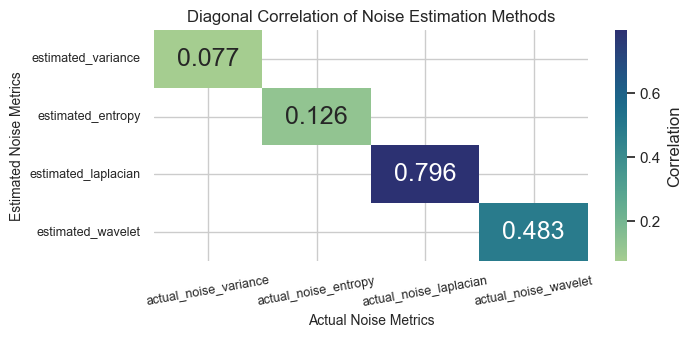

In [128]:
# Adjusting the visualization to display only the diagonal of the heatmap
plt.figure(figsize=(7, 3))

# Mask to only show diagonal elements
mask = np.ones_like(results_df.drop(columns=['image']).corr().iloc[4:,:4], dtype=bool)
np.fill_diagonal(mask, False)

# Create the heatmap with masking
heatmap = sns.heatmap(results_df.drop(columns=['image']).corr().iloc[4:,:4], annot=True, cmap="crest", fmt=".3f", cbar_kws={'label': 'Correlation'},
                      annot_kws={"size": 18},  # Increase annotation font size
                      mask=mask,  # Apply mask to hide non-diagonal elements
                      xticklabels=results_df.drop(columns=['image']).corr().iloc[4:,:4].columns, yticklabels=results_df.drop(columns=['image']).corr().iloc[4:,:4].index)
heatmap.tick_params(axis='x', labelsize=9)  # Make x-axis labels smaller
heatmap.tick_params(axis='y', labelsize=9)  # Make y-axis labels smaller
# Title and labels
plt.title("Diagonal Correlation of Noise Estimation Methods", fontsize=12)
plt.xlabel("Actual Noise Metrics", fontsize=10)
plt.ylabel("Estimated Noise Metrics", fontsize=10)
plt.xticks(rotation=10)

plt.show()


In [114]:
results_df['has_noise_variance'] = results_df['actual_noise_variance'].apply(lambda x: 0 if x == 0 else 1)
results_df['has_noise_entropy'] = results_df['actual_noise_entropy'].apply(lambda x: 0 if x == 0 else 1)
results_df['has_noise_laplacian'] = results_df['actual_noise_laplacian'].apply(lambda x: 0 if x == 0 else 1)
results_df['has_noise_wavelet'] = results_df['actual_noise_wavelet'].apply(lambda x: 0 if x == 0 else 1)

In [115]:
np.sum(
    np.sum(results_df['has_noise_variance'] != results_df['has_noise_entropy']),
    np.sum(results_df['has_noise_variance'] != results_df['has_noise_laplacian']),
    np.sum(results_df['has_noise_variance'] != results_df['has_noise_wavelet']))

0

In [116]:
results_df['has_noise'] = results_df['has_noise_variance']
results_df.drop(columns=['has_noise_variance', 'has_noise_entropy', 'has_noise_laplacian', 'has_noise_wavelet'], inplace=True)
results_df

image  actual_noise_variance  actual_noise_entropy  \
0   00000.jpg           14525.964284              3.923373   
1   00001.jpg               0.000000              0.000000   
2   00002.jpg           11960.238271              1.490547   
3   00003.jpg           12049.142796              2.416903   
4   00004.jpg               0.000000              0.000000   
5   00005.jpg           14342.956357              5.450147   
6   00006.jpg           13909.601249              5.777141   
7   00007.jpg           12909.449136              2.460633   
8   00008.jpg               0.000000              0.000000   
9   00009.jpg           14665.753460              3.542732   
10  00010.jpg               0.000000              0.000000   
11  00011.jpg               0.000000              0.000000   
12  00012.jpg           14298.093658              2.703818   
13  00013.jpg           10681.282524              2.316325   
14  00014.jpg           15667.809200              3.406949   
15  00015.jpg           15207.104597              2.462076   
16  00016.jpg           14230.554704              5.450832   
17  00017.jpg           13618.250257              3.206185   
18  00018.jpg           14365.519216              5.360296   
19  00019.jpg            6335.128807              2.611592   
20  00020.jpg           14257.511964              5.486852   
21  00021.jpg               0.000000              0.000000   
22  00022.jpg               0.000000              0.000000   
23  00023.jpg           14080.221721              5.518486   
24  00024.jpg               0.000000              0.000000   
25  00025.jpg           14757.124944              2.335213   
26  00026.jpg            4353.864621              4.503288   
27  00027.jpg               0.000000              0.000000   
28  00028.jpg           13753.434383              3.157719   
29  00029.jpg           14411.744445              5.380787   

    actual_noise_laplacian  actual_noise_wavelet  estimated_variance  \
0               129.978455             64.435640         2924.676346   
1                 0.000000              0.000000         2161.368158   
2                84.510540             48.935336          345.748662   
3               185.166918             77.336457         1536.520575   
4                 0.000000              0.000000         1777.972204   
5               486.417754            122.375834         2578.962610   
6               511.989311            123.170233         2103.235187   
7               146.661937             67.385408         2015.907565   
8                 0.000000              0.000000         1599.338253   
9               185.728638             78.986505         2754.994291   
10                0.000000              0.000000         1882.206092   
11                0.000000              0.000000         1019.285354   
12              191.968379             77.429770         1953.796745   
13              126.789770             62.694412         2302.083862   
14               59.183951             40.792956         1554.930055   
15              178.470625             75.382875         2442.770213   
16              489.700403            122.162418         1586.546330   
17              158.240518             71.891370          986.390020   
18              482.045879            121.619601          805.719260   
19               98.878410             56.228898          488.879065   
20              489.293913            122.298200         2323.776101   
21                0.000000              0.000000         2147.239312   
22                0.000000              0.000000         2974.970399   
23              504.287182            122.293538         1719.222434   
24                0.000000              0.000000         2543.604344   
25              190.607120             75.998276         1039.724819   
26               52.897124             41.290715          489.380853   
27                0.000000              0.000000         1509.856246 

## Find best threshold PR and ROC Curve

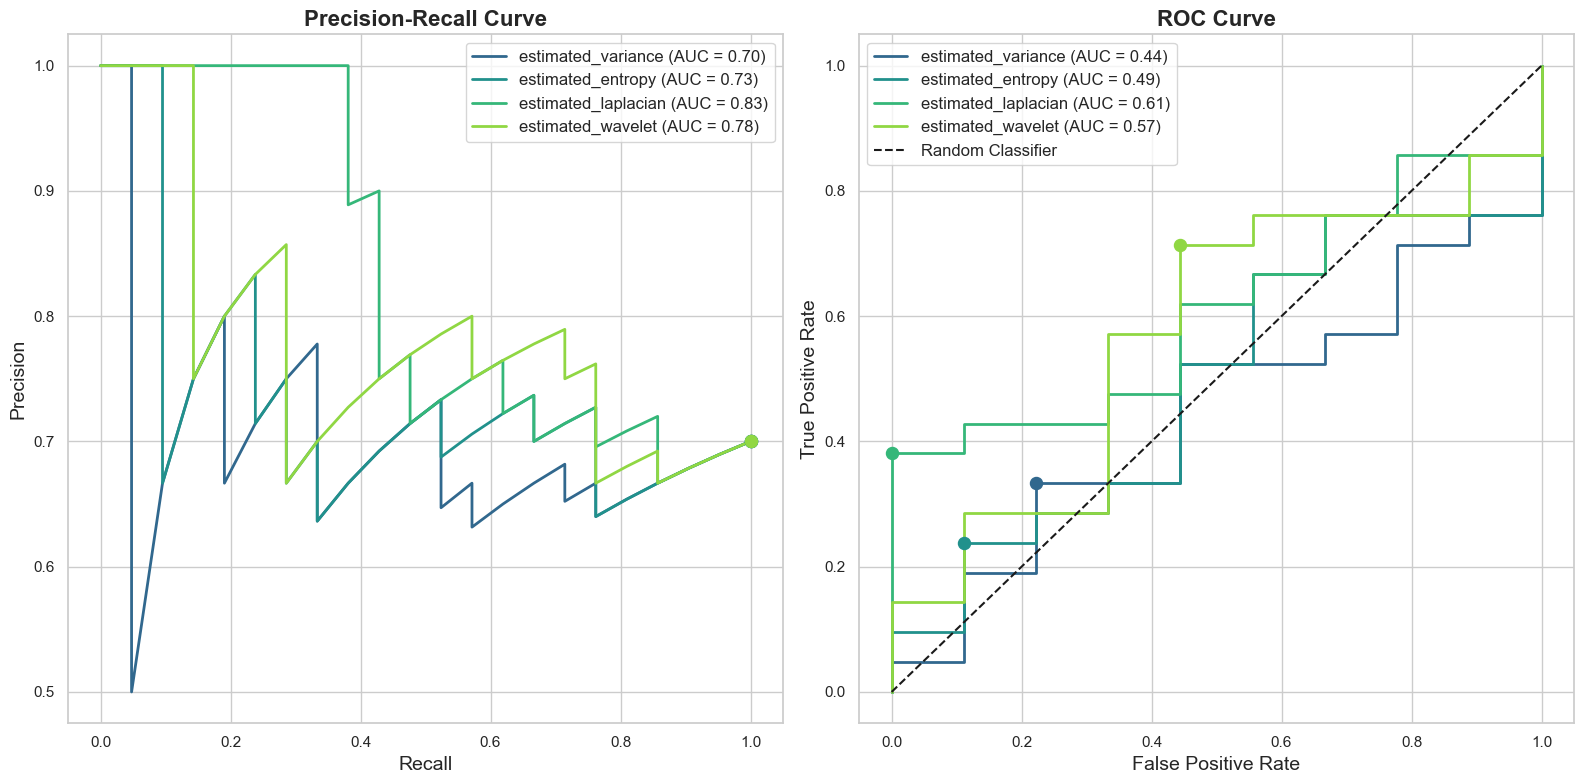

estimated_variance:
  PR_best_threshold = 345.749, Precision = 0.700, Recall = 1.000, F1 = 0.824
  ROC_best_threshold = 2302.084, TPR = 0.333, FPR = 0.222, Specificity = 0.778

estimated_entropy:
  PR_best_threshold = 5.620, Precision = 0.700, Recall = 1.000, F1 = 0.824
  ROC_best_threshold = 7.456, TPR = 0.238, FPR = 0.111, Specificity = 0.889

estimated_laplacian:
  PR_best_threshold = 3.845, Precision = 0.700, Recall = 1.000, F1 = 0.824
  ROC_best_threshold = 38.565, TPR = 0.381, FPR = 0.000, Specificity = 1.000

estimated_wavelet:
  PR_best_threshold = 3.545, Precision = 0.700, Recall = 1.000, F1 = 0.824
  ROC_best_threshold = 7.369, TPR = 0.714, FPR = 0.444, Specificity = 0.556



In [117]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import precision_recall_curve, roc_curve, auc

# Set Seaborn style and color palette
sns.set(style="whitegrid")
palette = sns.color_palette("viridis", 5)  # HUSL color palette with 4 colors for the 4 metrics

# Initialize dictionary to store optimal thresholds and their metrics
optimal_thresholds = {}

# Initialize plots for PR and ROC curves
fig, axes = plt.subplots(1, 2, figsize=(16, 8))

# Loop over each method and plot
for i, col in enumerate(['estimated_variance', 'estimated_entropy', 'estimated_laplacian', 'estimated_wavelet']):
    
    # Get true labels and scores
    y_true = results_df['has_noise']
    y_scores = results_df[col]
    
    # Compute Precision-Recall curve
    precision, recall, thresholds_pr = precision_recall_curve(y_true, y_scores)
    pr_auc = auc(recall, precision)
    axes[0].plot(recall, precision, label=f'{col} (AUC = {pr_auc:.2f})', color=palette[i+1], linewidth=2)
    
    # Find threshold with max F1 score for PR curve
    f1_scores = 2 * (precision * recall) / (precision + recall + 1e-6)  # Avoid division by zero
    best_idx_pr = np.argmax(f1_scores)
    best_threshold_pr = thresholds_pr[best_idx_pr]
    best_precision, best_recall = precision[best_idx_pr], recall[best_idx_pr]
    best_f1 = f1_scores[best_idx_pr]
    
    # Compute ROC curve
    fpr, tpr, thresholds_roc = roc_curve(y_true, y_scores)
    roc_auc = auc(fpr, tpr)
    axes[1].plot(fpr, tpr, label=f'{col} (AUC = {roc_auc:.2f})', color=palette[i+1], linewidth=2)

    # Find threshold that maximizes Youden's J statistic for ROC curve
    j_scores = tpr - fpr
    best_idx_roc = np.argmax(j_scores)
    best_threshold_roc = thresholds_roc[best_idx_roc]
    best_tpr, best_fpr = tpr[best_idx_roc], fpr[best_idx_roc]
    best_specificity = 1 - best_fpr
    
    # Store optimal thresholds and metrics
    optimal_thresholds[col] = {
        'PR_best_threshold': best_threshold_pr,
        'PR_precision': best_precision,
        'PR_recall': best_recall,
        'PR_F1': best_f1,
        'ROC_best_threshold': best_threshold_roc,
        'ROC_TPR': best_tpr,
        'ROC_FPR': best_fpr,
        'ROC_specificity': best_specificity
    }

    # Annotate the best threshold on PR curve
    axes[0].scatter(best_recall, best_precision, color=palette[i+1], marker='o', s=75, zorder=5)
    #axes[0].text(best_recall, best_precision, f'Thresh={best_threshold_pr:.2f}', verticalalignment='bottom', horizontalalignment='left', color=palette[i+1])

    # Annotate the best threshold on ROC curve
    axes[1].scatter(best_fpr, best_tpr, color=palette[i+1], marker='o', s=75, zorder=5)
    #axes[1].text(best_fpr, best_tpr, f'Thresh={best_threshold_roc:.2f}', verticalalignment='bottom', horizontalalignment='left', color=palette[i+1])

# Set labels and legends for Precision-Recall plot
axes[0].set_title('Precision-Recall Curve', fontsize=16, weight='bold')
axes[0].set_xlabel('Recall', fontsize=14)
axes[0].set_ylabel('Precision', fontsize=14)
axes[0].legend(loc='best', fontsize=12)
axes[0].grid(True)

# Set labels and legends for ROC plot
axes[1].plot([0, 1], [0, 1], 'k--', label='Random Classifier', linewidth=1.5)
axes[1].set_title('ROC Curve', fontsize=16, weight='bold')
axes[1].set_xlabel('False Positive Rate', fontsize=14)
axes[1].set_ylabel('True Positive Rate', fontsize=14)
axes[1].legend(loc='best', fontsize=12)
axes[1].grid(True)

plt.tight_layout()
plt.show()

# Display optimal thresholds and metrics for each method
for col, metrics in optimal_thresholds.items():
    print(f"{col}:")
    print(f"  PR_best_threshold = {metrics['PR_best_threshold']:.3f}, Precision = {metrics['PR_precision']:.3f}, Recall = {metrics['PR_recall']:.3f}, F1 = {metrics['PR_F1']:.3f}")
    print(f"  ROC_best_threshold = {metrics['ROC_best_threshold']:.3f}, TPR = {metrics['ROC_TPR']:.3f}, FPR = {metrics['ROC_FPR']:.3f}, Specificity = {metrics['ROC_specificity']:.3f}")
    print()



In [119]:
results_df['laplacian_binarized_th38.56'] = results_df['estimated_laplacian'].apply(lambda x: 0 if x < 38.56 else 1)
results_df['laplacian_binarized_th3.845'] = results_df['estimated_laplacian'].apply(lambda x: 0 if x < 3.845 else 1)
results_df

image  actual_noise_variance  actual_noise_entropy  \
0   00000.jpg           14525.964284              3.923373   
1   00001.jpg               0.000000              0.000000   
2   00002.jpg           11960.238271              1.490547   
3   00003.jpg           12049.142796              2.416903   
4   00004.jpg               0.000000              0.000000   
5   00005.jpg           14342.956357              5.450147   
6   00006.jpg           13909.601249              5.777141   
7   00007.jpg           12909.449136              2.460633   
8   00008.jpg               0.000000              0.000000   
9   00009.jpg           14665.753460              3.542732   
10  00010.jpg               0.000000              0.000000   
11  00011.jpg               0.000000              0.000000   
12  00012.jpg           14298.093658              2.703818   
13  00013.jpg           10681.282524              2.316325   
14  00014.jpg           15667.809200              3.406949   
15  00015.jpg           15207.104597              2.462076   
16  00016.jpg           14230.554704              5.450832   
17  00017.jpg           13618.250257              3.206185   
18  00018.jpg           14365.519216              5.360296   
19  00019.jpg            6335.128807              2.611592   
20  00020.jpg           14257.511964              5.486852   
21  00021.jpg               0.000000              0.000000   
22  00022.jpg               0.000000              0.000000   
23  00023.jpg           14080.221721              5.518486   
24  00024.jpg               0.000000              0.000000   
25  00025.jpg           14757.124944              2.335213   
26  00026.jpg            4353.864621              4.503288   
27  00027.jpg               0.000000              0.000000   
28  00028.jpg           13753.434383              3.157719   
29  00029.jpg           14411.744445              5.380787   

    actual_noise_laplacian  actual_noise_wavelet  estimated_variance  \
0               129.978455             64.435640         2924.676346   
1                 0.000000              0.000000         2161.368158   
2                84.510540             48.935336          345.748662   
3               185.166918             77.336457         1536.520575   
4                 0.000000              0.000000         1777.972204   
5               486.417754            122.375834         2578.962610   
6               511.989311            123.170233         2103.235187   
7               146.661937             67.385408         2015.907565   
8                 0.000000              0.000000         1599.338253   
9               185.728638             78.986505         2754.994291   
10                0.000000              0.000000         1882.206092   
11                0.000000              0.000000         1019.285354   
12              191.968379             77.429770         1953.796745   
13              126.789770             62.694412         2302.083862   
14               59.183951             40.792956         1554.930055   
15              178.470625             75.382875         2442.770213   
16              489.700403            122.162418         1586.546330   
17              158.240518             71.891370          986.390020   
18              482.045879            121.619601          805.719260   
19               98.878410             56.228898          488.879065   
20              489.293913            122.298200         2323.776101   
21                0.000000              0.000000         2147.239312   
22                0.000000              0.000000         2974.970399   
23              504.287182            122.293538         1719.222434   
24                0.000000              0.000000         2543.604344   
25              190.607120             75.998276         1039.724819   
26               52.897124             41.290715          489.380853   
27                0.000000              0.000000         1509.856246 

# DENOISING METHODS EXPLORATION

In [40]:
#imports
import os
import cv2
import pywt
import math
import lpips
import torch
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from skimage.metrics import structural_similarity as ssim

## Similarity metrics + change color space functions

In [41]:
def compute_bhattacharyya(image1, image2):
    if len(image1.shape) == 3: #assumeixo que image1 i image2 tenen mateixa shape
        channels = image1.shape[-1]
    else:
        channels = 1

    hist1 = []
    hist2 = []
    # Get histograms
    for c in range(channels):
        hist1.append(cv2.calcHist([image1], [c], None, [256], (0,256)))
        hist2.append(cv2.calcHist([image2], [c], None, [256], (0,256)))

    # Compute Bhattacharyya distance between histograms
    bh_dist = cv2.compareHist(hist1, hist2, cv2.HISTCMP_BHATTACHARYYA)

    # Return the Bhattacharyya similarity (1 - distance)
    return 1 - bh_dist

In [42]:
# Function to compute RMSE similarity between two images (directly on pixels)
def compute_rmse(image1, image2):
    # Convert images to float32 for precision
    image1 = image1.astype(np.float32)
    image2 = image2.astype(np.float32)
    
    # Compute RMSE
    mse = np.mean((image1 - image2) ** 2)
    rmse = np.sqrt(mse)
    
    # Return RMSE as a similarity measure
    return rmse

In [43]:
def compute_psnr(img1, img2):
    # img1 and img2 have range [0, 255]
    img1 = img1.astype(np.float64)
    img2 = img2.astype(np.float64)
    mse = np.mean((img1 - img2) ** 2)
    if mse == 0:
        return float("inf")
    return 20 * math.log10(255.0 / math.sqrt(mse))

In [44]:
def ssim(img1, img2):
    C1 = (0.01 * 255) ** 2
    C2 = (0.03 * 255) ** 2

    img1 = img1.astype(np.float64)
    img2 = img2.astype(np.float64)
    kernel = cv2.getGaussianKernel(11, 1.5)
    window = np.outer(kernel, kernel.transpose())

    mu1 = cv2.filter2D(img1, -1, window)[5:-5, 5:-5]  # valid
    mu2 = cv2.filter2D(img2, -1, window)[5:-5, 5:-5]
    mu1_sq = mu1 ** 2
    mu2_sq = mu2 ** 2
    mu1_mu2 = mu1 * mu2
    sigma1_sq = cv2.filter2D(img1 ** 2, -1, window)[5:-5, 5:-5] - mu1_sq
    sigma2_sq = cv2.filter2D(img2 ** 2, -1, window)[5:-5, 5:-5] - mu2_sq
    sigma12 = cv2.filter2D(img1 * img2, -1, window)[5:-5, 5:-5] - mu1_mu2

    ssim_map = ((2 * mu1_mu2 + C1) * (2 * sigma12 + C2)) / (
        (mu1_sq + mu2_sq + C1) * (sigma1_sq + sigma2_sq + C2)
    )
    return ssim_map.mean()

def compute_ssim(img1, img2):
    """calculate SSIM
    the same outputs as MATLAB's
    img1, img2: [0, 255]
    """
    if not img1.shape == img2.shape:
        raise ValueError("Input images must have the same dimensions.")
    if img1.ndim == 2:
        return ssim(img1, img2)
    elif img1.ndim == 3:
        if img1.shape[2] == 3:
            ssims = []
            for i in range(3):
                ssims.append(ssim(img1, img2))
            return np.array(ssims).mean()
        elif img1.shape[2] == 1:
            return ssim(np.squeeze(img1), np.squeeze(img2))
    else:
        raise ValueError("Wrong input image dimensions.")

In [45]:
# Function to calculate LPIPS metric between two images
def compute_lpips(image1, image2, net='alex'):
    """
    Compute the LPIPS metric between two images.
    
    Parameters:
    - image1: First image as a NumPy array (H x W x C), where C is 3 for RGB.
    - image2: Second image as a NumPy array (H x W x C), where C is 3 for RGB.
    - net: The network architecture used for LPIPS computation ('alex', 'vgg', 'squeeze'). Default is 'alex'.
    
    Returns:
    - lpips_distance: The LPIPS distance between image1 and image2.
    """
    # Convert images from NumPy to PyTorch Tensors and normalize to [-1, 1]
    # (LPIPS expects inputs in the range [-1, 1] and in the format (N, C, H, W))
    image1_torch = torch.from_numpy(image1).permute(2, 0, 1).unsqueeze(0).float() / 127.5 - 1.0
    image2_torch = torch.from_numpy(image2).permute(2, 0, 1).unsqueeze(0).float() / 127.5 - 1.0

    # Initialize the LPIPS model (choose the backbone: 'alex', 'vgg', 'squeeze')
    loss_fn = lpips.LPIPS(net=net)

    # Calculate LPIPS distance
    lpips_distance = loss_fn(image1_torch, image2_torch)

    return lpips_distance.item()

In [46]:
def calculate_similarity(image1, image2, method='ssim'):
    if method == 'bhattacharyya':
        return compute_bhattacharyya(image1, image2)
    elif method == 'rmse':
        return compute_rmse(image1, image2)
    elif method == 'psnr':
        return compute_psnr(image1, image2)
    elif method == 'ssim':
        return compute_ssim(image1, image2)
    elif method == 'lpips':
        return compute_lpips(image1, image2)
    else:
        raise ValueError(f"Unknown method: {method}.")

In [47]:
def change_color_space(image, color_space):
    # Change the color space of an image 
    
    if color_space == 'RGB':
        return image
    elif color_space == 'LAB':
        return cv2.cvtColor(image, cv2.COLOR_BGR2LAB)
    elif color_space == 'HSV':
        return cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    elif color_space == 'YCrCb':
        return cv2.cvtColor(image, cv2.COLOR_BGR2YCrCb)
    elif color_space == 'GRAY':
        return cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    else:
        raise ValueError(f"Unsupported color space: {color_space}")

## Laplacian Pyramid

In [48]:
def create_gaussian_pyramid(image, levels):
    pyramid = [image]
    for i in range(levels):
        image = cv2.pyrDown(image)
        pyramid.append(image)
    return pyramid

In [49]:
def create_laplacian_pyramid(gaussian_pyramid):
    laplacian_pyramid = []
    for i in range(len(gaussian_pyramid)-1, 0, -1):
        size = (gaussian_pyramid[i-1].shape[1], gaussian_pyramid[i-1].shape[0])
        expanded = cv2.pyrUp(gaussian_pyramid[i], dstsize=size)
        laplacian = cv2.subtract(gaussian_pyramid[i-1], expanded)
        laplacian_pyramid.append(laplacian)
    return laplacian_pyramid

In [50]:
def reconstruct_image(laplacian_pyramid, gaussian_base):
    current_image = gaussian_base
    for laplacian in laplacian_pyramid:
        size = (laplacian.shape[1], laplacian.shape[0])
        current_image = cv2.pyrUp(current_image, dstsize=size)
        current_image = cv2.add(current_image, laplacian)
    return current_image

## Filter functions

In [51]:
# Apply Gaussian, Median, Bilateral filters (same as before)
def apply_gaussian_filter(laplacian_pyramid, ksize):
    denoised_pyramid = []
    for i, lap in enumerate(laplacian_pyramid):
        if i < len(laplacian_pyramid):
            denoised_pyramid.append(cv2.GaussianBlur(lap, (ksize, ksize), 0))
        else:
            denoised_pyramid.append(lap)
    return denoised_pyramid

In [52]:
def apply_median_filter(laplacian_pyramid, ksize):
    denoised_pyramid = []
    for i, lap in enumerate(laplacian_pyramid):
        if i < len(laplacian_pyramid):
            denoised_pyramid.append(cv2.medianBlur(lap, ksize))
        else:
            denoised_pyramid.append(lap)
    return denoised_pyramid

In [53]:
def apply_bilateral_filter(laplacian_pyramid, d, sigma_color, sigma_space):
    denoised_pyramid = []
    for i, lap in enumerate(laplacian_pyramid):
        if i < len(laplacian_pyramid):
            denoised_pyramid.append(cv2.bilateralFilter(lap, d, sigma_color, sigma_space))
        else:
            denoised_pyramid.append(lap)
    return denoised_pyramid

In [54]:
# Function to apply NLM (Non-Local Means) denoising
def apply_nlm_filter(laplacian_pyramid, h):
    denoised_pyramid = []
    for lap in laplacian_pyramid:
        denoised_pyramid.append(cv2.fastNlMeansDenoising(lap, h[0], h[1], 7, 21))  # You can adjust the NLM parameters if needed
    return denoised_pyramid

### Wavelets

In [55]:
def wavelet_denoising(image, wavelet='db1', level=1, threshold_method='soft'):
    """
    Apply wavelet denoising to each channel of a color image.
    
    Args:
        image: Input RGB image (3D array).
        wavelet: Type of wavelet to use (e.g., 'db1' for Daubechies wavelets).
        level: The number of decomposition levels.
        threshold_method: Denoising threshold method ('soft' or 'hard').
    
    Returns:
        Denoised color image (3D array).
    """
    denoised_channels = []
    
    # Iterate over each channel (R, G, B)
    for i in range(3):
        channel = image[:, :, i]
        
        # Perform wavelet decomposition on the channel
        coeffs = pywt.wavedec2(channel, wavelet, level=level)
        
        # Apply thresholding on the detail coefficients for denoising
        threshold = lambda x: pywt.threshold(x, np.median(np.abs(x)) / 0.6745, mode=threshold_method)
        coeffs_denoised = [coeffs[0]] + [tuple(map(threshold, coeff)) for coeff in coeffs[1:]]
        
        # Perform wavelet reconstruction with denoised coefficients
        denoised_channel = pywt.waverec2(coeffs_denoised, wavelet)
        
        # Clip to valid pixel range and add to the list of denoised channels
        denoised_channel = np.clip(denoised_channel, 0, 255).astype(np.uint8)
        denoised_channels.append(denoised_channel)
    
    # Stack the denoised channels to get the denoised color image
    denoised_image = np.stack(denoised_channels, axis=-1)
    
    return denoised_image

In [56]:
from skimage.restoration import denoise_wavelet
import matplotlib.pyplot as plt

# Function to apply wavelet denoising
def wavelet_denoising_skimage(image, wavelet='db1', mode='soft', rescale_sigma=True):
    """
    Apply wavelet denoising using skimage's denoise_wavelet function.

    Parameters:
        image (ndarray): Input noisy color image.
        wavelet (str): Type of wavelet to use (e.g., 'db1' for Daubechies).
        mode (str): Thresholding mode ('soft' or 'hard').
        rescale_sigma (bool): Whether to rescale the noise's standard deviation.

    Returns:
        ndarray: Denoised image.
    """
    # Perform wavelet denoising
    denoised_image = denoise_wavelet(image, wavelet=wavelet, mode=mode, rescale_sigma=rescale_sigma)
    
    # Convert to uint8 format for visualization
    denoised_image = (denoised_image * 255).astype(np.uint8)
    
    return denoised_image

### Discrete Cosine Transform (DCT)

In [57]:
def apply_dct_denoising(image, threshold=30):
    """Apply DCT-based denoising on an image."""
    # Convert image to float32 for better precision in the DCT process
    image = np.float32(image) / 255.0
    
    # Apply DCT to each color channel separately
    dct_channels = []
    for i in range(3):  # Assuming RGB
        # Apply 2D DCT (Discrete Cosine Transform)
        dct = cv2.dct(image[:, :, i])
        
        # Zero out small coefficients (thresholding)
        dct[np.abs(dct) < threshold] = 0
        
        # Apply inverse DCT to reconstruct the denoised channel
        idct = cv2.idct(dct)
        dct_channels.append(idct)
    
    # Merge the three channels back into an image
    denoised_image = cv2.merge(dct_channels)
    
    # Clip values to [0, 1] range and convert back to uint8
    denoised_image = np.clip(denoised_image * 255, 0, 255).astype(np.uint8)
    
    return denoised_image

### High Pass filter enhancement

In [58]:
def high_pass_filter(image, ksize=5):
    """Apply a high-pass filter to the image."""
    # Apply a Gaussian blur to get low-frequency components
    low_pass = cv2.GaussianBlur(image, (ksize, ksize), 0)
    # Subtract low-frequency components from the original image
    high_pass = cv2.subtract(image, low_pass)
    return high_pass

In [59]:
def enhance_image_with_hp(denoised_image, ksize=5):
    """Enhance the denoised image using high-pass filtering."""
    high_pass_details = high_pass_filter(denoised_image, ksize)
    # Add high-frequency details back to the denoised image
    enhanced_image = cv2.add(denoised_image, high_pass_details)
    return enhanced_image

## Comparison table for best parameters

In [60]:
def compare_filters_table(noisy_dir, gt_dir, similarity_metric='psnr', color_space = 'RGB'):
    """
    Load all noisy and ground truth (GT) images from the given directories and
    compare them using various filters based on the specified similarity metric.
    
    Args:
        noisy_dir: Path to the directory containing noisy images.
        gt_dir: Path to the directory containing ground truth (GT) images.
        similarity_metric: The similarity measure to use ('psnr', 'lpips', 'rmse', 'ssim', 'bhattacharyya').
        
    Returns:
        A Pandas DataFrame containing the best similarity results for each filter.
    """
    all_results = []
    
    # Get list of image filenames in the noisy directory
    noisy_filenames = os.listdir(noisy_dir)
    
    for noisy_filename in noisy_filenames:
        if noisy_filename.endswith('.jpg'):
            # Construct full file paths for noisy and GT images
            noisy_path = os.path.join(noisy_dir, noisy_filename)
            gt_path = os.path.join(gt_dir, noisy_filename)
            
            # Check if the corresponding GT image exists
            if os.path.exists(gt_path):
                # Load both noisy and GT images
                noisy_image = cv2.imread(noisy_path, cv2.IMREAD_COLOR)
                gt_image = cv2.imread(gt_path, cv2.IMREAD_COLOR)
                
                # Get comparison results for the current image
                best_results_df = compare_filters_for_image(noisy_image, gt_image, noisy_filename, similarity_metric, color_space)
                all_results.append(best_results_df)
            else:
                print(f"Warning: GT image not found for {noisy_filename}")

    # Combine results for all images into a single DataFrame
    combined_results_df = pd.concat(all_results, ignore_index=True)
    
    return combined_results_df


def compare_filters_for_image(image, gt_image, image_name, similarity_metric, color_space):
    # Convert both images to the selected color space (only once)
        noisy_image_cs = change_color_space(image, color_space=color_space)
        gt_image_cs = change_color_space(gt_image, color_space=color_space)

        # Calculate similarity before filtering
        similarity_before = calculate_similarity(noisy_image_cs, gt_image_cs, method=similarity_metric)

        # Try different parameters for each filter

        # Gaussian Blur - Different kernel sizes
        gb_sims = []
        for k in [(3, 3), (5, 5), (7, 7)]:
            gb_img = cv2.GaussianBlur(image, k, 0)
            gb_sims.append((k, calculate_similarity(gb_img, gt_image_cs, method=similarity_metric)))
        
        # Median Blur - Different kernel sizes
        mb_sims = []
        for k in [3, 5, 7]:
            mb_img = cv2.medianBlur(image, k)
            mb_sims.append((k, calculate_similarity(mb_img, gt_image_cs, method=similarity_metric)))
        
        # Bilateral Filter - Different d, sigmaColor, sigmaSpace
        bb_sims = []
        for (d, sigma_color, sigma_space) in [(9, 75, 75), (9, 100, 100), (9, 150, 150)]:
            bb_img = cv2.bilateralFilter(image, d, sigma_color, sigma_space)
            bb_sims.append(((d, sigma_color, sigma_space), calculate_similarity(bb_img, gt_image_cs, method=similarity_metric)))

        # Non-Local Means (NLM) - Different h parameters
        nlm_sims = []
        for (h_luminance, h_color) in [(10, 10), (7, 21), (15, 15)]:
            nlm_img = cv2.fastNlMeansDenoisingColored(image, None, h_luminance, h_color, 7, 21)
            nlm_sims.append(((h_luminance, h_color), calculate_similarity(nlm_img, gt_image_cs, method=similarity_metric)))

        # List of metrics where higher values are better
        higher_better_metrics = ['psnr', 'ssim']

        # List of metrics where lower values are better
        lower_better_metrics = ['rmse', 'lpips', 'bhattacharyya']

        # Find the best parameters for each filter based on the similarity metric
        if similarity_metric in higher_better_metrics:
            best_gb_sim = max(gb_sims, key=lambda x: x[1])
            best_mb_sim = max(mb_sims, key=lambda x: x[1])
            best_bb_sim = max(bb_sims, key=lambda x: x[1])
            best_nlm_sim = max(nlm_sims, key=lambda x: x[1])
        elif similarity_metric in lower_better_metrics:
            best_gb_sim = min(gb_sims, key=lambda x: x[1])
            best_mb_sim = min(mb_sims, key=lambda x: x[1])
            best_bb_sim = min(bb_sims, key=lambda x: x[1])
            best_nlm_sim = min(nlm_sims, key=lambda x: x[1])
        else:
            raise ValueError(f"Unsupported similarity metric: {similarity_metric}")
        
        # Store the results for this image
        results = {
            'Image': image_name,
            'Similarity (Before)': similarity_before,
            'Best Gaussian Blur (Kernel)': best_gb_sim[0],
            'Gaussian Blur (Similarity)': best_gb_sim[1],
            'Best Median Blur (Kernel)': best_mb_sim[0],
            'Median Blur (Similarity)': best_mb_sim[1],
            'Best Bilateral Filter (Params)': best_bb_sim[0],
            'Bilateral Filter (Similarity)': best_bb_sim[1],
            'Best NLM (Params)': best_nlm_sim[0],
            'NLM (Similarity)': best_nlm_sim[1]
        }
        
        results_df = pd.DataFrame([results])
        return results_df



In [61]:
noisy_directory = '/Users/abriil/Uni/master/C1/data/qsd1_w3'
gt_directory = '/Users/abriil/Uni/master/C1/data/qsd1_w3/non_augmented'

results_df = compare_filters_table(noisy_dir=noisy_directory , gt_dir=gt_directory, similarity_metric='ssim', color_space='RGB')

In [62]:
results_df.to_csv(f'comparison_results1.csv', index=False)
results_df

Image  Similarity (Before) Best Gaussian Blur (Kernel)  \
0   00025.jpg             0.987918                      (3, 3)   
1   00019.jpg             0.981071                      (3, 3)   
2   00018.jpg             0.353998                      (7, 7)   
3   00024.jpg             1.000000                      (3, 3)   
4   00026.jpg             0.700596                      (7, 7)   
5   00027.jpg             1.000000                      (3, 3)   
6   00023.jpg             0.333423                      (7, 7)   
7   00022.jpg             1.000000                      (3, 3)   
8   00008.jpg             1.000000                      (3, 3)   
9   00020.jpg             0.513334                      (5, 5)   
10  00021.jpg             1.000000                      (3, 3)   
11  00009.jpg             0.985260                      (3, 3)   
12  00004.jpg             1.000000                      (3, 3)   
13  00010.jpg             1.000000                      (3, 3)   
14  00011.jpg             1.000000                      (3, 3)   
15  00005.jpg             0.573529                      (5, 5)   
16  00013.jpg             0.988711                      (3, 3)   
17  00007.jpg             0.988354                      (3, 3)   
18  00006.jpg             0.734556                      (3, 3)   
19  00012.jpg             0.982403                      (3, 3)   
20  00016.jpg             0.431233                      (7, 7)   
21  00002.jpg             0.993025                      (3, 3)   
22  00003.jpg             0.992782                      (3, 3)   
23  00017.jpg             0.980458                      (3, 3)   
24  00029.jpg             0.440861                      (7, 7)   
25  00001.jpg             1.000000                      (3, 3)   
26  00015.jpg             0.990239                      (3, 3)   
27  00014.jpg             0.987327                      (3, 3)   
28  00000.jpg             0.955112                      (3, 3)   
29  00028.jpg             0.995443                      (3, 3)   

    Gaussian Blur (Similarity)  Best Median Blur (Kernel)  \
0                     0.968249                          3   
1                     0.961745                          3   
2                     0.887907                          7   
3                     0.947940                          3   
4                     0.738355                          7   
5                     0.852761                          3   
6                     0.747957                          7   
7                     0.958665                          3   
8                     0.977670                          3   
9                     0.783101                          3   
10                    0.979302                          3   
11                    0.903910                          3   
12                    0.963799                          3   
13                    0.967353                          3   
14                    0.951239                          3   
15                    0.836553                          3   
16                    0.968242                          3   
17                    0.974796                          3   
18                    0.715077                          3   
19                    0.953710                          3   
20                    0.796465                          3   
21                    0.972861                          3   
22                    0.960341                          3   
23                    0.956629                          3   
24                    0.865802                          5   
25                    0.969905                          3   
26                    0.962002                          3   
27                    0.982130                          3   
28                    0.894696                          3   
29                    0.909763                          3   

    Median Blur (Similarity) Best Bilateral Filter (Params)  \
0     

## Grid search over Gaussian-Laplace Pyramids

In [63]:
noisy_directory = '/Users/abriil/Uni/master/C1/data/qsd1_w3'
gt_directory = '/Users/abriil/Uni/master/C1/data/qsd1_w3/non_augmented'

noisy_images = []
gt_images = []

# Process all images in the folder
for img_name in os.listdir(noisy_directory):
    if img_name.endswith('.jpg'):
        # Load noisy image in RGB and corresponding ground truth image
        noisy_image_path = os.path.join(noisy_directory, img_name)
        gt_image_path = os.path.join(gt_directory, img_name)

        noisy_image = cv2.imread(noisy_image_path, cv2.IMREAD_COLOR)
        gt_image = cv2.imread(gt_image_path, cv2.IMREAD_COLOR)

        noisy_images.append(noisy_image)
        gt_images.append(gt_image)

In [64]:
# Store the results of each combination
results = []

# Define grid search ranges for parameters
levels_range = [3, 5, 7]  # Pyramid levels to test
gaussian_kernel_sizes = [3, 5, 7]  # Gaussian kernel sizes
median_kernel_sizes = [3, 5, 7]  # Median kernel sizes
bilateral_params = [(9, 75, 75), (9, 100, 100), (9, 150, 150)]  # Bilateral filter params (d, sigma_color, sigma_space)
nlm_params = [(10, 10), (7, 21), (15, 15)]
comparison_method = 'ssim'  # Choose 'mse', 'psnr', 'ssim', or 'lpips'

# Loop over the noisy and ground truth images in parallel
for noisy_image, gt_image in zip(noisy_images, gt_images):
    
    for levels in levels_range:
        # Step 1: Create Gaussian and Laplacian Pyramids
        gaussian_pyramid = create_gaussian_pyramid(noisy_image, levels)
        laplacian_pyramid = create_laplacian_pyramid(gaussian_pyramid)
        
        # 1. Gaussian Filters
        for ksize in gaussian_kernel_sizes:
            denoised_laplacian_pyramid = apply_gaussian_filter(laplacian_pyramid, ksize)
            denoised_image = reconstruct_image(denoised_laplacian_pyramid, gaussian_pyramid[-1])
            similarity = calculate_similarity(gt_image, denoised_image, method=comparison_method)
            results.append({
                'method': 'Gaussian',
                'levels': levels,
                'kernel_size': ksize,
                'similarity': similarity
            })
        
        # 2. Median Filters
        for ksize in median_kernel_sizes:
            denoised_laplacian_pyramid = apply_median_filter(laplacian_pyramid, ksize)
            denoised_image = reconstruct_image(denoised_laplacian_pyramid, gaussian_pyramid[-1])
            similarity = calculate_similarity(gt_image, denoised_image, method=comparison_method)
            results.append({
                'method': 'Median',
                'levels': levels,
                'kernel_size': ksize,
                'similarity': similarity
            })
        
        # 3. Bilateral Filters
        for (d, sigma_color, sigma_space) in bilateral_params:
            denoised_laplacian_pyramid = apply_bilateral_filter(laplacian_pyramid, d, sigma_color, sigma_space)
            denoised_image = reconstruct_image(denoised_laplacian_pyramid, gaussian_pyramid[-1])
            similarity = calculate_similarity(gt_image, denoised_image, method=comparison_method)
            results.append({
                'method': 'Bilateral',
                'levels': levels,
                'd': d,
                'sigma_color': sigma_color,
                'sigma_space': sigma_space,
                'similarity': similarity
            })
        
        # 4. NLM Filters
        for h in nlm_params:
            denoised_laplacian_pyramid = apply_nlm_filter(laplacian_pyramid, h)
            denoised_image = reconstruct_image(denoised_laplacian_pyramid, gaussian_pyramid[-1])
            similarity = calculate_similarity(gt_image, denoised_image, method=comparison_method)
            results.append({
                'method': 'NLM',
                'levels': levels,
                'h': h,
                'similarity': similarity
            })
        

In [66]:
# Create a DataFrame to store the results
df = pd.DataFrame(results)

# Save results to a CSV file for analysis
df.to_csv('denoising_grid_search_results.csv', index=False)

# Summarize results
best_result = df[df['similarity'] == df['similarity'].max()]
print(f'Best configuration:\n{best_result}')

Best configuration:
       method  levels  kernel_size  similarity   d  sigma_color  sigma_space  \
972  Gaussian       3          3.0    0.938573 NaN          NaN          NaN   

       h  
972  NaN  


/var/folders/5y/ljztfs697fqf9rvmq2qtpg3m0000gn/T/ipykernel_7808/2541138918.py:26: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  boxplot = sns.boxplot(x='method', y='similarity', data=df,


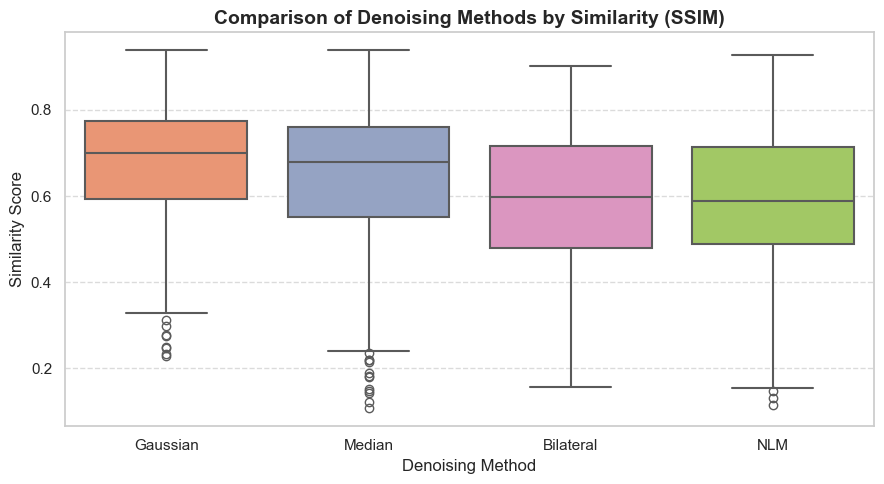

In [67]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Load the results from CSV
df = pd.read_csv('denoising_grid_search_results.csv')

# Define a consistent color palette for the methods
unique_methods = df['method'].unique()
# Define method names and color mapping
method_names = {
    'original': 'Original Image',
    'Gaussian': 'Gaussian Blur',
    'Median': 'Median Blur',
    'Bilateral': 'Bilateral Filter',
    'NLM': 'Non-Local Means Denoising'
}

# Create a consistent color palette based on the method names
colors = sns.color_palette('Set2', len(method_names))
color_mapping = dict(zip(method_names.values(), colors))  # Fixed color mapping for methods

# Plot similarity score for different filter methods (Boxplot)
sns.set(style='whitegrid')  # Use a white grid background
plt.figure(figsize=(9, 5))
boxplot = sns.boxplot(x='method', y='similarity', data=df, 
                      palette=[color_mapping[method_names[m]] for m in df['method'].unique()],  # Use the custom color mapping
                      linewidth=1.5)   # Thicker lines for better visibility
plt.title('Comparison of Denoising Methods by Similarity (SSIM)', fontsize=14, fontweight='bold')
plt.xlabel('Denoising Method', fontsize=12)
plt.ylabel('Similarity Score', fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()  # Adjust layout to prevent clipping of labels
plt.show()

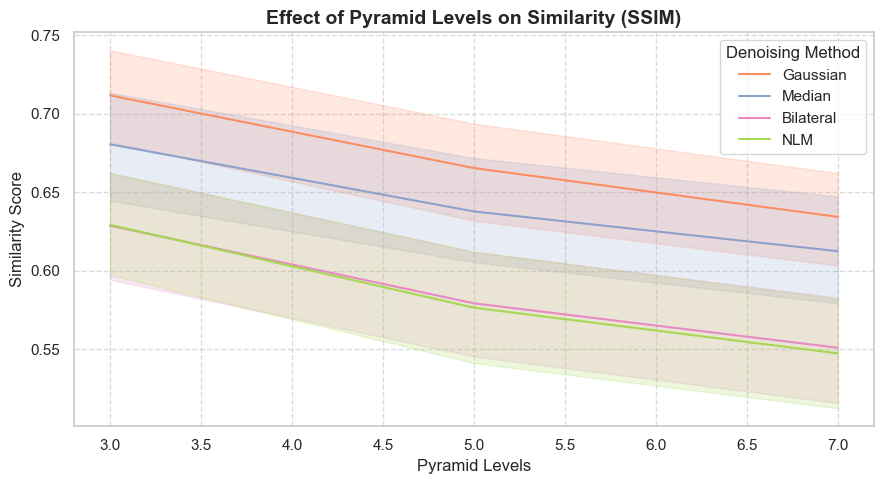

In [68]:
# Plot similarity score as a function of pyramid levels (Lineplot)
plt.figure(figsize=(9, 5))
sns.lineplot(x='levels', y='similarity', hue='method', data=df, palette=[color_mapping[method_names[m]] for m in df['method'].unique()])  # Use the same color mapping
plt.title('Effect of Pyramid Levels on Similarity (SSIM)', fontsize=14, fontweight='bold')
plt.xlabel('Pyramid Levels', fontsize=12)
plt.ylabel('Similarity Score', fontsize=12)
plt.legend(title='Denoising Method')  # Add a legend with title
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()  # Adjust layout to prevent clipping of labels
plt.show()


## Different plots for low-pass filters

In [69]:
similarity_dict = {'original': [], 'gb': [], 'mb': [], 'bb': [], 'nlm': []}
comparison_method = 'ssim'
for img, gt_img in zip(noisy_images, gt_images):

    gb_img = cv2.GaussianBlur(img, (5, 5), 0)
    mb_img = cv2.medianBlur(img, 5)
    bb_img = cv2.bilateralFilter(img, 9, 75, 75)
    nlm_img = cv2.fastNlMeansDenoisingColored(img, None, 10, 10, 7, 21)

    for denoised_img, method in zip([img, gb_img, mb_img, bb_img, nlm_img], ['original', 'gb', 'mb', 'bb', 'nlm']):
        similarity = calculate_similarity(gt_img, denoised_img, comparison_method)
        #print(f'{method}: {similarity}')
        similarity_dict[method].append(similarity)

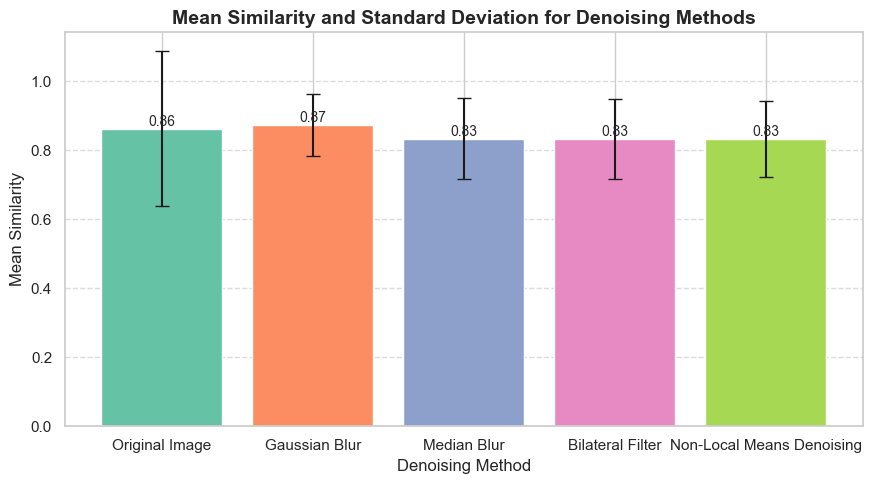

In [70]:
import numpy as np
import matplotlib.pyplot as plt


methods = list(similarity_dict.keys())
means = []
std_devs = []

# Calculate mean and standard deviation for each method
for method in methods:
    means.append(np.mean(similarity_dict[method]))
    std_devs.append(np.std(similarity_dict[method]))

method_names = {
    'original': 'Original Image',
    'gb': 'Gaussian Blur',
    'mb': 'Median Blur',
    'bb': 'Bilateral Filter',
    'nlm': 'Non-Local Means Denoising'
}

# Define a consistent color palette
colors = sns.color_palette('Set2', len(methods))  # Create a color palette for methods

plt.figure(figsize=(9, 5))


bars = plt.bar(methods, means, yerr=std_devs, capsize=5, color=colors)

plt.xlabel('Denoising Method', fontsize=12)
plt.ylabel('Mean Similarity', fontsize=12)
plt.title('Mean Similarity and Standard Deviation for Denoising Methods', fontsize=14, fontweight='bold')

plt.xticks(ticks=range(len(methods)), labels=[method_names[method] for method in methods])
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Adding value labels on top of the bars
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, f'{yval:.2f}', ha='center', va='bottom', fontsize=10)

plt.tight_layout()  # Adjust layout to prevent clipping of labels
plt.show()


In [71]:
similarity_dict = {
    'method': [],
    'levels': [],
    'kernel_size': [],
    'similarity': [],
    'd': [],
    'sigma_color': [],
    'sigma_space': []
}

# Configuration parameters
kernel_sizes = [3, 5, 7]  # Kernel sizes for Gaussian and Median filters
bilateral_params = [(9, 75, 75), (9, 100, 100), (9, 150, 150)]  # (d, sigma_color, sigma_space)

comparison_method = 'ssim'  # Change to your preferred metric (e.g., 'mse', 'psnr', 'ssim', 'lpips')

# Loop over each noisy image and its corresponding ground truth
for img, gt_img in zip(noisy_images, gt_images):

    # Test Gaussian Blur with different kernel sizes
    for ksize in kernel_sizes:
        gb_img = cv2.GaussianBlur(img, (ksize, ksize), 0)
        similarity = calculate_similarity(gt_img, gb_img, comparison_method)
        similarity_dict['method'].append('Gaussian')
        similarity_dict['levels'].append(np.nan)  # Not applicable for Gaussian
        similarity_dict['kernel_size'].append(ksize)
        similarity_dict['similarity'].append(similarity)
        similarity_dict['d'].append(np.nan)
        similarity_dict['sigma_color'].append(np.nan)
        similarity_dict['sigma_space'].append(np.nan)
    
    # Test Median Blur with different kernel sizes
    for ksize in kernel_sizes:
        mb_img = cv2.medianBlur(img, ksize)
        similarity = calculate_similarity(gt_img, mb_img, comparison_method)
        similarity_dict['method'].append('Median')
        similarity_dict['levels'].append(np.nan)  # Not applicable for Median
        similarity_dict['kernel_size'].append(ksize)
        similarity_dict['similarity'].append(similarity)
        similarity_dict['d'].append(np.nan)
        similarity_dict['sigma_color'].append(np.nan)
        similarity_dict['sigma_space'].append(np.nan)

    # Test Bilateral Filter with different parameters
    for (d, sigma_color, sigma_space) in bilateral_params:
        bb_img = cv2.bilateralFilter(img, d, sigma_color, sigma_space)
        similarity = calculate_similarity(gt_img, bb_img, comparison_method)
        similarity_dict['method'].append('Bilateral')
        similarity_dict['levels'].append(np.nan)  # Not applicable for Bilateral
        similarity_dict['kernel_size'].append(np.nan)
        similarity_dict['similarity'].append(similarity)
        similarity_dict['d'].append(d)
        similarity_dict['sigma_color'].append(sigma_color)
        similarity_dict['sigma_space'].append(sigma_space)

    # Test Non-Local Means Denoising (NLM)
    nlm_img = cv2.fastNlMeansDenoisingColored(img, None, 10, 10, 7, 21)
    similarity = calculate_similarity(gt_img, nlm_img, comparison_method)
    similarity_dict['method'].append('NLM')
    similarity_dict['levels'].append(np.nan)  # Not applicable for NLM
    similarity_dict['kernel_size'].append(np.nan)
    similarity_dict['similarity'].append(similarity)
    similarity_dict['d'].append(np.nan)
    similarity_dict['sigma_color'].append(np.nan)
    similarity_dict['sigma_space'].append(np.nan)

# Convert results to a DataFrame
results_df = pd.DataFrame(similarity_dict)

# Save the results to a CSV file
results_df.to_csv('denoising_results.csv', index=False)

print("Denoising results saved to 'denoising_results.csv'.")

Denoising results saved to 'denoising_results.csv'.


/var/folders/5y/ljztfs697fqf9rvmq2qtpg3m0000gn/T/ipykernel_7808/471562202.py:27: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='method', y='similarity', data=results_df,


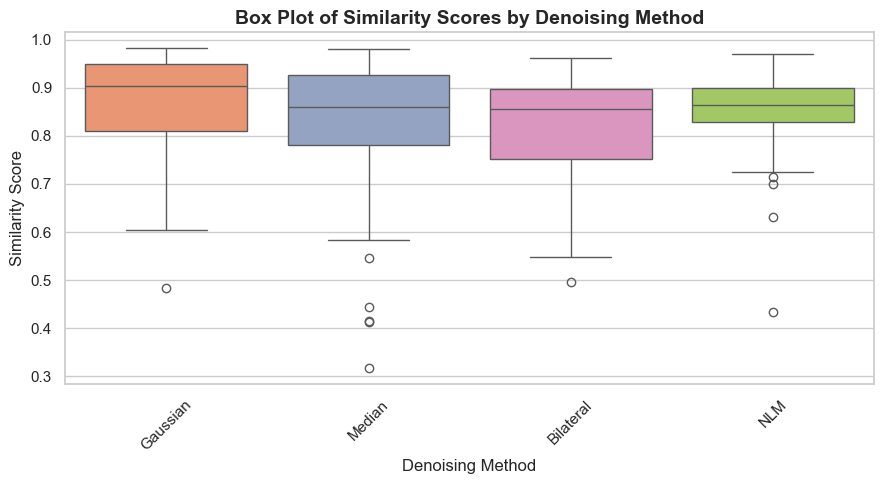

/var/folders/5y/ljztfs697fqf9rvmq2qtpg3m0000gn/T/ipykernel_7808/471562202.py:40: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='method', y='similarity', data=mean_scores,


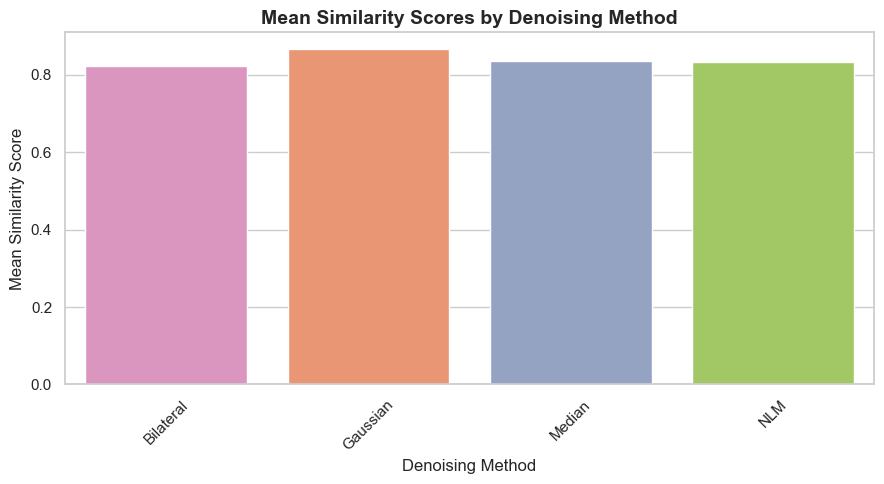

/var/folders/5y/ljztfs697fqf9rvmq2qtpg3m0000gn/T/ipykernel_7808/471562202.py:52: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x='method', y='similarity', data=results_df, inner='quartile',


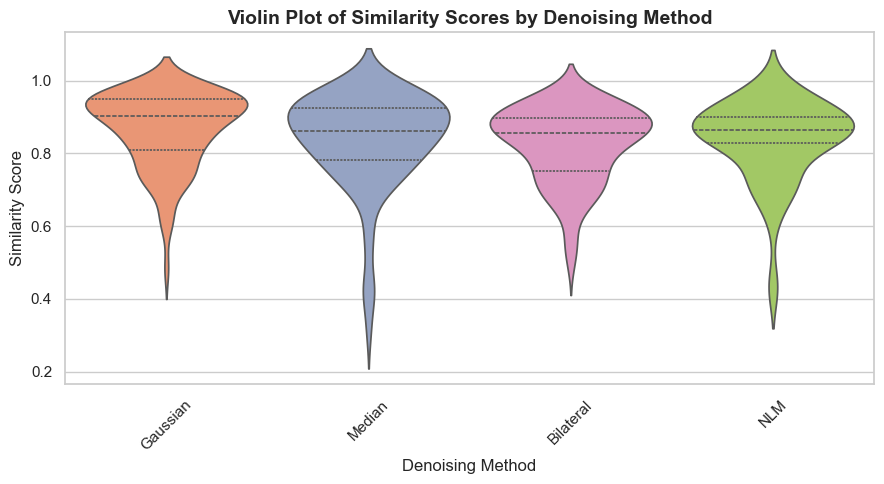

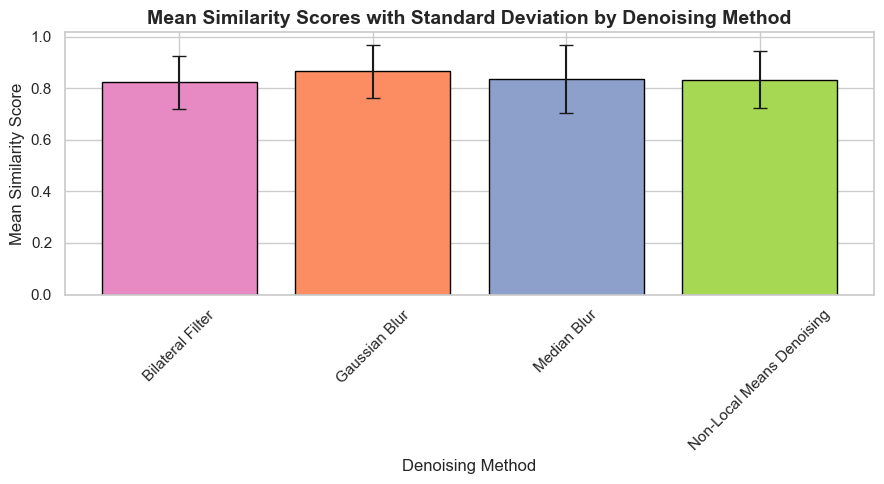

In [75]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load results from the CSV file
results_df = pd.read_csv('denoising_results.csv')

# Define method names and color mapping
method_names = {
    'original': 'Original Image',
    'Gaussian': 'Gaussian Blur',
    'Median': 'Median Blur',
    'Bilateral': 'Bilateral Filter',
    'NLM': 'Non-Local Means Denoising'
}

# Create a consistent color palette based on the method names
colors = sns.color_palette('Set2', len(method_names))
color_mapping = dict(zip(method_names.values(), colors))  # Fixed color mapping for methods

# Set seaborn style
sns.set(style='whitegrid')

# Box Plot for Similarity Scores by Method
plt.figure(figsize=(9, 5))
sns.boxplot(x='method', y='similarity', data=results_df,
            palette=[color_mapping[method_names[m]] for m in results_df['method'].unique()])
plt.title('Box Plot of Similarity Scores by Denoising Method', fontsize=14, fontweight='bold')
plt.xlabel('Denoising Method', fontsize=12)
plt.ylabel('Similarity Score', fontsize=12)
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig('box_plot_similarity_scores.png')  # Save the figure
plt.show()

# Bar Plot for Mean Similarity Scores by Method
mean_scores = results_df.groupby('method')['similarity'].mean().reset_index()
plt.figure(figsize=(9, 5))
sns.barplot(x='method', y='similarity', data=mean_scores,
            palette=[color_mapping[method_names[m]] for m in mean_scores['method'].unique()])
plt.title('Mean Similarity Scores by Denoising Method', fontsize=14, fontweight='bold')
plt.xlabel('Denoising Method', fontsize=12)
plt.ylabel('Mean Similarity Score', fontsize=12)
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig('mean_similarity_scores.png')  # Save the figure
plt.show()

# Violin Plot for Similarity Scores by Method
plt.figure(figsize=(9, 5))
sns.violinplot(x='method', y='similarity', data=results_df, inner='quartile',
               palette=[color_mapping[method_names[m]] for m in results_df['method'].unique()])
plt.title('Violin Plot of Similarity Scores by Denoising Method', fontsize=14, fontweight='bold')
plt.xlabel('Denoising Method', fontsize=12)
plt.ylabel('Similarity Score', fontsize=12)
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig('violin_plot_similarity_scores.png')  # Save the figure
plt.show()

# Calculate mean and standard deviation of similarity scores by method
mean_std_scores = results_df.groupby('method')['similarity'].agg(['mean', 'std']).reset_index()

# Map method names for better readability in the plot
mean_std_scores['method'] = mean_std_scores['method'].map(method_names)

# Bar Plot for Mean Similarity Scores with Error Bars for Standard Deviation
plt.figure(figsize=(9, 5))
plt.bar(x=mean_std_scores['method'], height=mean_std_scores['mean'],
        yerr=mean_std_scores['std'], color=[color_mapping[method] for method in mean_std_scores['method']],
        capsize=5, edgecolor='black')

# Set plot title and labels
plt.title('Mean Similarity Scores with Standard Deviation by Denoising Method', fontsize=14, fontweight='bold')
plt.xlabel('Denoising Method', fontsize=12)
plt.ylabel('Mean Similarity Score', fontsize=12)
plt.xticks(rotation=45)
plt.tight_layout()

# Save and display the plot
plt.savefig('mean_std_similarity_scores.png')  # Save the figure
plt.show()


## Similarity with and without high pass filtering

In [117]:
# Define a function to analyze similarity with and without high-pass filtering
def analyze_high_pass_filtering(noisy_images, gt_images, comparison_method='ssim'):
    similarity_dict = {'method': [], 'similarity': []}

    for img, gt_img in zip(noisy_images, gt_images):
        # Apply different denoising methods
        denoised_images = {
            'gb': cv2.GaussianBlur(img, (5, 5), 0),
            'mb': cv2.medianBlur(img, 5),
            'bb': cv2.bilateralFilter(img, 9, 75, 75),
            'nlm': cv2.fastNlMeansDenoisingColored(img, None, 10, 10, 7, 21)
        }

        # Analyze each method with and without high-pass filtering
        for method, denoised_img in denoised_images.items():
            # Calculate similarity without high-pass filtering
            similarity_no_hp = calculate_similarity(gt_img, denoised_img, method=comparison_method)
            similarity_dict['method'].append(f"{method} (no HP)")
            similarity_dict['similarity'].append(similarity_no_hp)

            # Enhance using high-pass filtering
            enhanced_img = enhance_image_with_hp(denoised_img, ksize=5)

            # Calculate similarity with high-pass filtering
            similarity_hp = calculate_similarity(gt_img, enhanced_img, method=comparison_method)
            similarity_dict['method'].append(f"{method} (with HP)")
            similarity_dict['similarity'].append(similarity_hp)

    return pd.DataFrame(similarity_dict)

# Run the analysis
comparison_method = 'ssim'  # or 'psnr', etc.
results_hp_analysis = analyze_high_pass_filtering(noisy_images, gt_images, comparison_method)

# Save results to CSV
results_hp_analysis.to_csv('high_pass_filtering_results.csv', index=False)


/var/folders/5y/ljztfs697fqf9rvmq2qtpg3m0000gn/T/ipykernel_22633/1354645861.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='method', y='similarity', data=results_hp_analysis, palette=repeating_palette, showmeans=True)


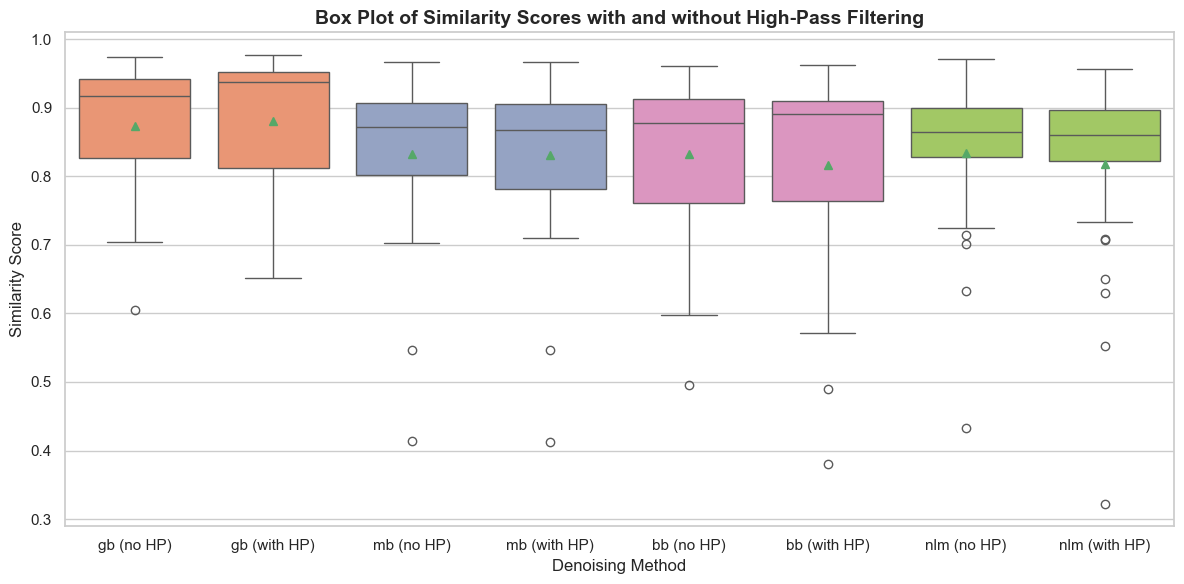

In [148]:
import seaborn as sns
import matplotlib.pyplot as plt

# Define a custom color palette where colors repeat every two methods
custom_palette = sns.color_palette('Set2', 5)  # Define three unique colors
repeating_palette = [custom_palette[(i // 2)+1] for i in range(len(results_hp_analysis['method'].unique()))]

# Visualize results with High-Pass Filtering
plt.figure(figsize=(12, 6))

# Use the repeating palette for consistent colors in pairs
sns.boxplot(x='method', y='similarity', data=results_hp_analysis, palette=repeating_palette, showmeans=True)

plt.title('Box Plot of Similarity Scores with and without High-Pass Filtering', fontsize=14, fontweight='bold')
plt.xlabel('Denoising Method', fontsize=12)
plt.ylabel('Similarity Score', fontsize=12)
plt.tight_layout()

# Save the plot
plt.savefig('hp_filtering_box_plot_repeating_colors.png')
plt.show()


## Wavelet filtering

In [265]:
wavelet_similarities = []

for img, gt_img in zip(noisy_images, gt_images):
    # Apply wavelet denoising
    wavelet_denoised_img = wavelet_denoising_skimage(img)  # Use the updated color version
    
    # Resize the denoised image to match the dimensions of the ground truth
    if wavelet_denoised_img.shape != gt_img.shape:
        wavelet_denoised_img = cv2.resize(wavelet_denoised_img, (gt_img.shape[1], gt_img.shape[0]))
    
    # Compute similarity metrics (SSIM in this case)
    similarity_wavelet = calculate_similarity(gt_img, wavelet_denoised_img, method='ssim')
    
    # Append the result to the similarity dictionary
    wavelet_similarities.append(similarity_wavelet)

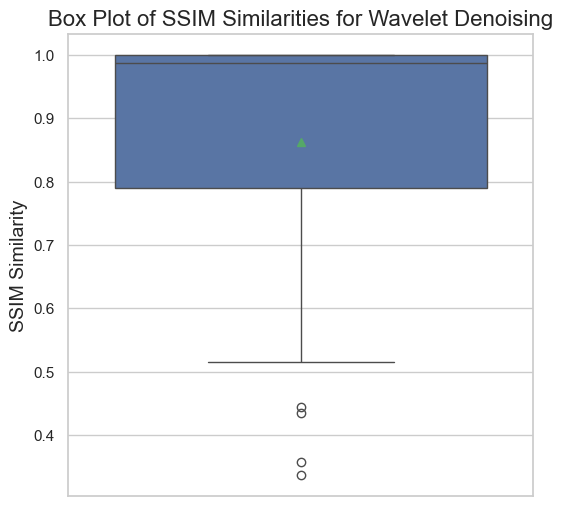

In [266]:
# Create a DataFrame to structure the data for plotting
df_wavelet = pd.DataFrame({
    'similarity': wavelet_similarities
})

# Create the box plot
plt.figure(figsize=(6, 6))
sns.boxplot(data=df_wavelet, y='similarity', showmeans=True)

# Add title and labels
plt.title('Box Plot of SSIM Similarities for Wavelet Denoising', fontsize=16)
plt.ylabel('SSIM Similarity', fontsize=14)

# Show the plot
plt.show()

## DCT filtering

In [151]:
dct_similarities = []

# Example usage
for img, gt_img in zip(noisy_images, gt_images):
    dct_denoised_img = apply_dct_denoising(img)
    
    # Calculate similarity (e.g., SSIM)
    similarity_dct = calculate_similarity(gt_img, dct_denoised_img, method='ssim')
    dct_similarities.append(similarity_dct)

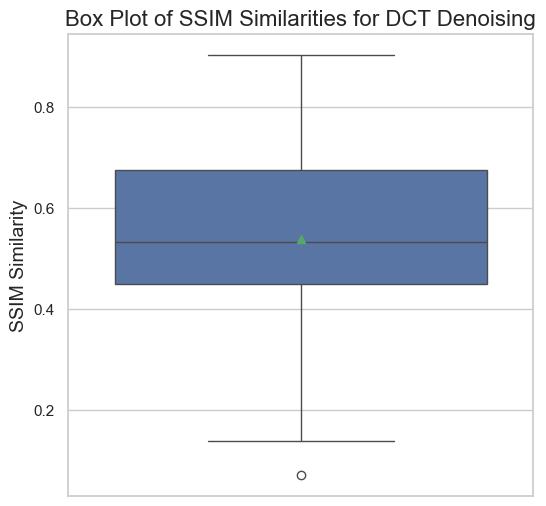

In [152]:
# Create a DataFrame to structure the data for plotting
df_dct = pd.DataFrame({
    'similarity': dct_similarities
})

# Create the box plot
plt.figure(figsize=(6, 6))
sns.boxplot(data=df_dct, y='similarity', showmeans=True)

# Add title and labels
plt.title('Box Plot of SSIM Similarities for DCT Denoising', fontsize=16)
plt.ylabel('SSIM Similarity', fontsize=14)

# Show the plot
plt.show()

## Visualize Results for the different implemented methods

imatge salt and pepper: '/Users/abriil/Uni/master/C1/data/qsd1_w3/00016.jpg'
imatge canvi colors: '/Users/abriil/Uni/master/C1/data/qsd1_w3/00000.jpg'

In [130]:
# Functions to plot our results
def plot_input(img, title):
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.imshow(img)
    plt.title(title), plt.xticks([]), plt.yticks([])
    plt.show()

In [131]:
# Step-by-step denoising and reconstruction for each color channel
def process_channel(image_channel, levels, filter_method, kernel_size, apply_high_pass=False, ksize_hp=5, d=9, sigma_color=75, sigma_space=75, h=10, wavelet='db1', level_wavelet=1, threshold_method='soft', dct_threshold=30):
    # Step 1: Create Gaussian and Laplacian Pyramids (only for Laplacian pyramid-based filters)
    if filter_method in ['Median', 'Gaussian', 'Bilateral', 'NLM']:
        gaussian_pyramid = create_gaussian_pyramid(image_channel, levels)
        laplacian_pyramid = create_laplacian_pyramid(gaussian_pyramid)

    # Step 2: Apply the chosen filter method
    if filter_method == 'Median':
        denoised_laplacian_pyramid = apply_median_filter(laplacian_pyramid, kernel_size)
    elif filter_method == 'Gaussian':
        denoised_laplacian_pyramid = apply_gaussian_filter(laplacian_pyramid, kernel_size)
    elif filter_method == 'Bilateral':
        denoised_laplacian_pyramid = apply_bilateral_filter(laplacian_pyramid, d, sigma_color, sigma_space)
    elif filter_method == 'NLM':  # Non-Local Means
        denoised_laplacian_pyramid = apply_nlm_filter(laplacian_pyramid, h)
    elif filter_method == 'Wavelet':  # Wavelet denoising option
        return wavelet_denoising(image_channel, wavelet=wavelet, level=level_wavelet, threshold_method=threshold_method)
    elif filter_method == 'DCT':  # DCT-based denoising option
        return apply_dct_denoising(image_channel, threshold=dct_threshold)
    else:
        raise ValueError(f"Unknown filter method: {filter_method}")

    # Step 3: Reconstruct the Image (for pyramid-based methods)
    denoised_image = reconstruct_image(denoised_laplacian_pyramid, gaussian_pyramid[-1])

    # Step 4: Optionally apply the high-pass filter
    if apply_high_pass:
        denoised_image = enhance_image_with_hp(denoised_image, ksize_hp)
    
    return denoised_image

def process_image(image_path, gt_path, levels=3, kernel_size=3, filter_method='Median', apply_high_pass=False, ksize_hp=5, d=9, sigma_color=75, sigma_space=75, h=10, wavelet='db1', level_wavelet=1, threshold_method='soft', dct_threshold=30, similarity_method='ssim'):
    # Load the color image and ground truth image
    image_color = cv2.imread(image_path)  # Load a color image
    gt_image = cv2.imread(gt_path)

    # Convert from BGR to RGB for consistency with Matplotlib
    image_color_rgb = cv2.cvtColor(image_color, cv2.COLOR_BGR2RGB)
    gt_image_rgb = cv2.cvtColor(gt_image, cv2.COLOR_BGR2RGB)

    # Split the image into its color channels (B, G, R)
    b_channel, g_channel, r_channel = cv2.split(image_color)

    # Process each channel (B, G, R) separately using the selected filter method
    if filter_method in ['Wavelet', 'DCT']:
        # Process the entire image for Wavelet or DCT denoising
        if filter_method == 'Wavelet':
            denoised_image_color = wavelet_denoising(image_color, wavelet=wavelet, level=level_wavelet, threshold_method=threshold_method)
            denoised_image_color = cv2.cvtColor(denoised_image_color, cv2.COLOR_BGR2RGB)
        elif filter_method == 'DCT':
            denoised_image_color = apply_dct_denoising(image_color, threshold=dct_threshold)
            denoised_image_color = cv2.cvtColor(denoised_image_color, cv2.COLOR_BGR2RGB)
    else:
        # Process each channel separately for pyramid-based methods
        b_denoised = process_channel(b_channel, levels, filter_method, kernel_size, apply_high_pass, ksize_hp, d, sigma_color, sigma_space, h, wavelet, level_wavelet, threshold_method, dct_threshold)
        g_denoised = process_channel(g_channel, levels, filter_method, kernel_size, apply_high_pass, ksize_hp, d, sigma_color, sigma_space, h, wavelet, level_wavelet, threshold_method, dct_threshold)
        r_denoised = process_channel(r_channel, levels, filter_method, kernel_size, apply_high_pass, ksize_hp, d, sigma_color, sigma_space, h, wavelet, level_wavelet, threshold_method, dct_threshold)

        # Merge the channels back to form the denoised color image
        denoised_image_color = cv2.merge([r_denoised, g_denoised, b_denoised])

    # Calculate similarity before and after denoising
    similarity_before = calculate_similarity(image_color_rgb, gt_image_rgb, method=similarity_method)
    similarity_after = calculate_similarity(denoised_image_color, gt_image_rgb, method=similarity_method)

    # Print results
    print(f'{levels} Level Laplacian Pyramid with filter: {filter_method}, kernel {kernel_size}x{kernel_size}')
    if filter_method == 'Wavelet':
        print(f'Wavelet denoising applied with wavelet: {wavelet}, level: {level_wavelet}, threshold method: {threshold_method}')
    elif filter_method == 'DCT':
        print(f'DCT denoising applied with threshold: {dct_threshold}')
    if apply_high_pass:
        print(f'High-pass filter applied with kernel size {ksize_hp}')
    print(f'Similarity with gt before any filters: {similarity_before}')
    print(f'Similarity with gt after filters: {similarity_after}')

    # Plot original and denoised images using Matplotlib
    plt.figure(figsize=(10, 5))

    # Plot original image
    plt.subplot(1, 2, 1)
    plt.imshow(image_color_rgb)
    plt.title('Original Image')
    plt.axis('off')

    # Plot denoised image
    plt.subplot(1, 2, 2)
    plt.imshow(denoised_image_color)
    plt.title('Denoised Image')
    plt.axis('off')

    # Show the plots
    plt.tight_layout()
    plt.show()

    # Optionally, save the denoised image
    cv2.imwrite('denoised_image_color.jpg', denoised_image_color)


In [132]:
img_path1 = '/Users/abriil/Uni/master/C1/data/qsd1_w3/00016.jpg'
gt_path1 = '/Users/abriil/Uni/master/C1/data/qsd1_w3/non_augmented/00016.jpg'

3 Level Laplacian Pyramid with filter: Median, kernel 3x3
High-pass filter applied with kernel size 5
Similarity with gt before any filters: 0.4312329268895681
Similarity with gt after filters: 0.7364510428659136


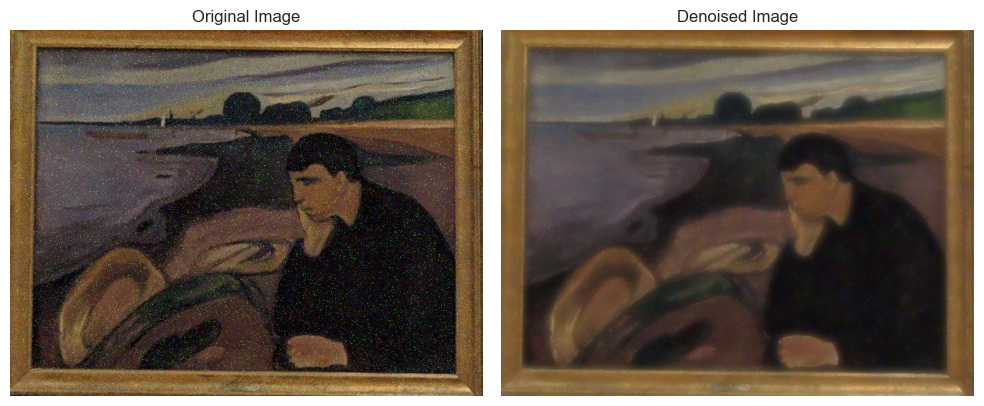

In [133]:
# Process an image with Median filter and apply high-pass filtering
process_image(
    image_path=img_path1,
    gt_path=gt_path1,
    levels=3,
    filter_method='Median',
    kernel_size=3,
    apply_high_pass=True,  # Apply high-pass filter
    ksize_hp=5,  # High-pass kernel size
    similarity_method='ssim'
)

3 Level Laplacian Pyramid with filter: Gaussian, kernel 5x5
Similarity with gt before any filters: 0.4312329268895681
Similarity with gt after filters: 0.6656297473943567


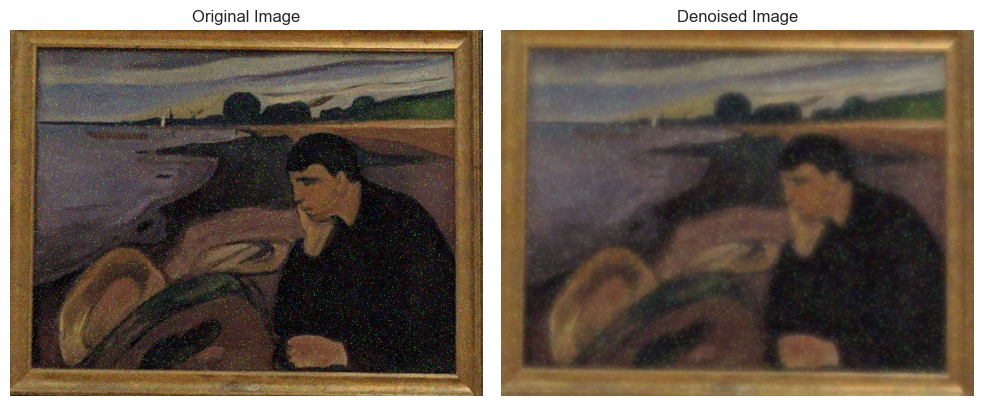

In [134]:
# Process an image with Gaussian filter without high-pass filtering
process_image(
    image_path=img_path1,
    gt_path=gt_path1,
    levels=3,
    filter_method='Gaussian',
    kernel_size=5,
    apply_high_pass=False,  # Do not apply high-pass filter
    similarity_method='ssim'
)

3 Level Laplacian Pyramid with filter: Wavelet, kernel 3x3
Wavelet denoising applied with wavelet: db1, level: 2, threshold method: soft
Similarity with gt before any filters: 0.4312329268895681
Similarity with gt after filters: 0.5372060203779246


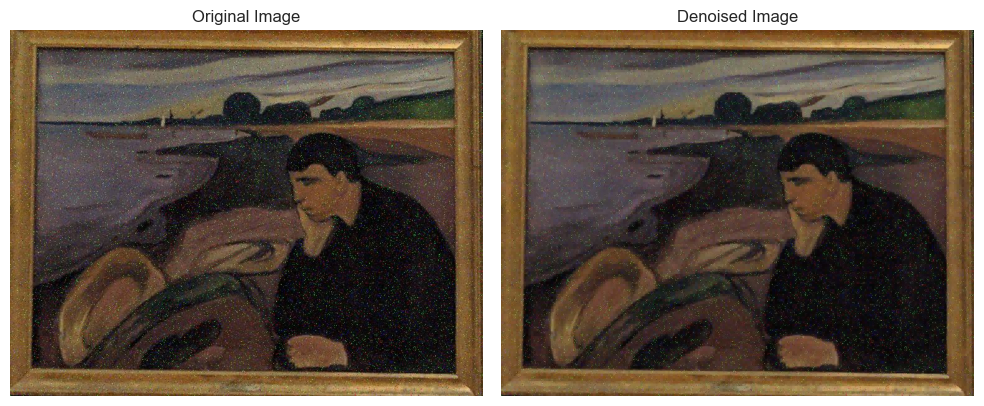

In [135]:
#Process an image with Wavelet denoising
process_image(
    image_path=img_path1,
    gt_path=gt_path1,
    filter_method='Wavelet',  # Select Wavelet denoising
    wavelet='db1',  # Wavelet type
    level_wavelet=2,  # Decomposition level
    threshold_method='soft',  # Thresholding method
    similarity_method='ssim'
)

3 Level Laplacian Pyramid with filter: DCT, kernel 3x3
DCT denoising applied with threshold: 2
Similarity with gt before any filters: 0.4312329268895681
Similarity with gt after filters: 0.6338765568173294


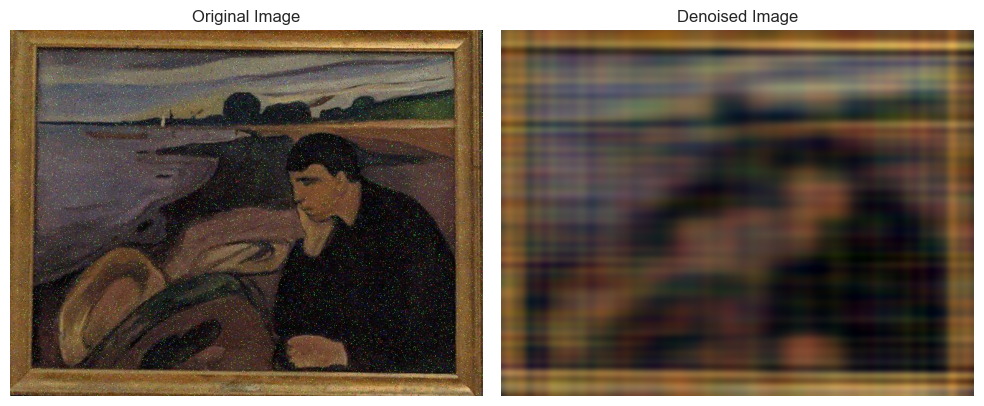

In [137]:
#Process an image with DCT denoising
process_image(
    image_path=img_path1,
    gt_path=gt_path1,
    filter_method='DCT',  # Select DCT denoising
    dct_threshold=2,  # Threshold for DCT coefficients
    similarity_method='ssim'
)

# GENERATE DATASET FOR THE DESIRED METHOD

In [278]:
import cv2
import numpy as np
import os
import pywt  # Ensure you have the PyWavelets package installed

# Helper to create and denoise Laplacian Pyramid
def laplacian_pyramid_denoising(image, lowpass_params, pyramid_levels, method):
    gaussian_pyramid = create_gaussian_pyramid(image, pyramid_levels)
    laplacian_pyramid = create_laplacian_pyramid(gaussian_pyramid)

    # Apply specified lowpass filter on the Laplacian pyramid
    if method == 'gaussian':
        denoised_pyramid = apply_gaussian_filter(laplacian_pyramid, **lowpass_params)
    elif method == 'median':
        denoised_pyramid = apply_median_filter(laplacian_pyramid, **lowpass_params)
    elif method == 'bilateral':
        denoised_pyramid = apply_bilateral_filter(laplacian_pyramid, **lowpass_params)
    elif method == 'nlm':
        denoised_pyramid = apply_nlm_filter(laplacian_pyramid, **lowpass_params)
    else:
        raise ValueError(f"Unsupported lowpass filter in Laplacian Pyramid: {method}")

    return reconstruct_image(denoised_pyramid, gaussian_pyramid[-1])

# Hub function to apply selected denoising method
def apply_denoising(image, method, lowpass_params=None, highpass=False, wavelet_params=None, dct_params=None, pyramid_levels=None):
    # Select denoising method
    if pyramid_levels:
        denoised_image = laplacian_pyramid_denoising(image, lowpass_params, pyramid_levels, method)

    elif method == 'wavelet' and wavelet_params:
        denoised_image = wavelet_denoising_skimage(image, **wavelet_params)

    elif method == 'dct' and dct_params:
        denoised_image = apply_dct_denoising(image, **dct_params)
    
    elif method == 'gaussian':
        denoised_image = cv2.GaussianBlur(image, (lowpass_params['ksize'], lowpass_params['ksize']), 0)

    elif method == 'median':
        denoised_image = cv2.medianBlur(image, lowpass_params['ksize'])

    elif method == 'bilateral':
        d, sigma_color, sigma_space = lowpass_params['d'], lowpass_params['sigma_color'], lowpass_params['sigma_space']
        denoised_image = cv2.bilateralFilter(image, d, sigma_color, sigma_space)
    
    elif method == 'nlm':
        h_luminance, h_color = lowpass_params['h_luminance'], lowpass_params['h_color']
        denoised_image = cv2.fastNlMeansDenoising(image, None, h_luminance, h_color, 7, 21)

    else:
        raise ValueError(f"Unsupported denoising method: {method}")

    # Apply additional high-pass filtering if requested
    if highpass:
        denoised_image = enhance_image_with_hp(denoised_image, ksize=5)

    return denoised_image

def create_denoised_dataset(noisy_dataset_path, denoised_dataset_path, method, lowpass_params=None, highpass=False, wavelet_params=None, dct_params=None, pyramid_levels=None, noise_method=None, noise_threshold=0):
    """
    Create a denoised dataset from a noisy dataset.

    Parameters:
    - noisy_dataset_path: Path to the directory containing noisy images.
    - denoised_dataset_path: Path to save denoised images.
    - method: The denoising method ('gaussian', 'median', 'bilateral', 'nlm', 'wavelet', 'dct', 'laplacian', 'lowpass_highpass').
    - lowpass_params: Parameters for low-pass filtering.
    - highpass: Boolean to indicate if a high-pass filter should be applied after denoising.
    - wavelet_params: Parameters for wavelet denoising.
    - dct_params: Parameters for DCT denoising.
    - pyramid_levels: Number of levels for Laplacian pyramid processing.
    - noise_method: Method for estimating noise ('variance', 'entropy', 'laplacian', 'wavelet').
    - noise_threshold: Threshold for noise estimation to decide whether to denoise the image.
    """

    # Create the denoised dataset directory if it doesn't exist
    os.makedirs(denoised_dataset_path, exist_ok=True)

    # Iterate over all images in the noisy dataset directory
    for filename in os.listdir(noisy_dataset_path):
        if filename.lower().endswith('.jpg'):  # Check for valid image file extensions
            # Construct the full path to the noisy image
            noisy_image_path = os.path.join(noisy_dataset_path, filename)

            # Read the noisy image
            noisy_image = cv2.imread(noisy_image_path)

            if not noise_method:
                denoised_image = apply_denoising(
                        noisy_image,
                        method,
                        lowpass_params=lowpass_params,
                        highpass=highpass,
                        wavelet_params=wavelet_params,
                        dct_params=dct_params,
                        pyramid_levels=pyramid_levels
                    )
                
                denoised_image_path = os.path.join(denoised_dataset_path, filename)
                cv2.imwrite(denoised_image_path, denoised_image)

            else:
                # Estimate the noise level using the specified method
                if noise_method == 'variance':
                    noise_estimate = variance_noise_estimation(noisy_image, 'grayscale')
                elif noise_method == 'entropy':
                    noise_estimate = entropy_noise_estimation(noisy_image, 'grayscale')
                elif noise_method == 'laplacian':
                    noise_estimate = laplacian_noise_estimation(noisy_image, 'grayscale')
                elif noise_method == 'wavelet':
                    noise_estimate = wavelet_noise_estimation(noisy_image, 'grayscale')
                else:
                    raise ValueError(f"Unsupported noise estimation method: {noise_method}")

                # Print the noise estimate for debugging
                #print(f"Noise estimate for {filename}: {noise_estimate}")

                # Decide whether to denoise based on the estimated noise
                if noise_estimate > noise_threshold:
                    # Apply the denoising method
                    denoised_image = apply_denoising(
                        noisy_image,
                        method,
                        lowpass_params=lowpass_params,
                        highpass=highpass,
                        wavelet_params=wavelet_params,
                        dct_params=dct_params,
                        pyramid_levels=pyramid_levels
                    )

                    # Save the denoised image
                    denoised_image_path = os.path.join(denoised_dataset_path, filename)
                    cv2.imwrite(denoised_image_path, denoised_image)
                    #print(f"Denoised image saved to: {denoised_image_path}")
                else:
                    print(f"Skipping denoising for {filename} due to low noise estimate.")
            



### Create denoised_1:
- gaussian, ksize = 3 #best params found
- no pyramid
- no noise estimation #apply denoising to every image
- no highpass to enhance

In [42]:
create_denoised_dataset(
    noisy_dataset_path = 'data/qsd1_w3',
    denoised_dataset_path = 'data/denoised_1',
    method='gaussian',  # Choose your denoising method
    lowpass_params={'ksize': 3},  # Example parameters
    highpass=False
)

### Create denoised_2:
- gaussian, ksize = 3 #best params found
- no pyramid
- no noise estimation #apply denoising to every image
- highpass to enhance

In [43]:
create_denoised_dataset(
    noisy_dataset_path = 'data/qsd1_w3',
    denoised_dataset_path = 'data/denoised_2',
    method='gaussian',  # Choose your denoising method
    lowpass_params={'ksize': 3},  # Example parameters
    highpass=True
)

### Create denoised_3:
- gaussian, ksize = 3 #best params found
- no pyramid
- noise estimation = laplacian, threshold = 35.35 #apply denoising to only some images where estimated noise is higher than threshold
- highpass to enhance

In [44]:
create_denoised_dataset(
    noisy_dataset_path = 'data/qsd1_w3',
    denoised_dataset_path = 'data/denoised_3',
    method='gaussian',  # Choose your denoising method
    lowpass_params={'ksize': 3},  # Example parameters
    highpass=True,
    noise_method='laplacian',
    noise_threshold=35.35
)

Skipping denoising for 00000.jpg due to low noise estimate.
Skipping denoising for 00001.jpg due to low noise estimate.
Skipping denoising for 00002.jpg due to low noise estimate.
Skipping denoising for 00003.jpg due to low noise estimate.
Skipping denoising for 00004.jpg due to low noise estimate.
Skipping denoising for 00007.jpg due to low noise estimate.
Skipping denoising for 00008.jpg due to low noise estimate.
Skipping denoising for 00009.jpg due to low noise estimate.
Skipping denoising for 00010.jpg due to low noise estimate.
Skipping denoising for 00011.jpg due to low noise estimate.
Skipping denoising for 00012.jpg due to low noise estimate.
Skipping denoising for 00013.jpg due to low noise estimate.
Skipping denoising for 00014.jpg due to low noise estimate.
Skipping denoising for 00015.jpg due to low noise estimate.
Skipping denoising for 00017.jpg due to low noise estimate.
Skipping denoising for 00019.jpg due to low noise estimate.
Skipping denoising for 00021.jpg due to 

### Create denoised_4:
- gaussian, ksize = 3 #best params found
- laplacian pyramid, levels = 3
- no noise estimation #apply denoising to every image
- highpass to enhance

In [45]:
create_denoised_dataset(
    noisy_dataset_path = 'data/qsd1_w3',
    denoised_dataset_path = 'data/denoised_4',
    method='gaussian',  # Choose your denoising method
    pyramid_levels=3,
    lowpass_params={'ksize': 3},  # Example parameters
    highpass=True
)

### Create denoised_5:
- wavelets, wavelet='db1', level=1, threshold_method='soft'
- no noise estimation #apply denoising to every image
- no highpass to enhance

In [283]:
create_denoised_dataset(
    noisy_dataset_path = '/Users/abriil/Uni/master/C1/data/qsd1_w3',
    denoised_dataset_path = '/Users/abriil/Uni/master/C1/data/denoised_5',
    method='wavelet',  # Choose your denoising method
    wavelet_params={'wavelet':'db1', 'mode':'soft', 'rescale_sigma':True},  # Example parameters
    highpass=False
)  # , wavelet='db1', mode='soft', rescale_sigma=True